# High Value Customer Identification

# Planejamento da Solução

## Input - Entrada

### Problema de Negócio

1. Selecionar os mais valiosos clientes para formar o programa de fidelidade **"INSIDERS"**
2. Conjunto de dados com as vendas de produtos durante 1 ano ( Nov 2015 to Dec 2017 )


## Output - Saída
 
1. A indicação de pessoas para fazer parte do programa de fidelidade **"INSIDERS"**.
2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks - Processo

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?

    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
        - Faturamento:
            - Alto Ticket Médio
            - Alto LTV
            - Baixa Recência ou Alta Frequência ( tempo entre as compras ) 
            - Alto Basket Size ( quantidade média de produtos comprados )
            - Baixa probabilidade de Churn
            - Previsão alta de LTV
            - Alta propensão de compra
        #
        - Custo:
            - Baixo número de devoluções
        #
        - Experiência:  
            - Média alta de avaliações

#
2. Quantos clientes farão parte do grupo?

    - Número de clientes
    - % em relação ao total de clientes

#
3. Quais as principais características desses clientes?
    - Escrever os principais atributos dos clientes
        - Idade
        - País
        - Salário
    #
    - Escrever os principais comportamentos de compra dos clientes ( métricas de negócio )
        - Vide acima

#
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?

    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.

#
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?

    - Cálculo do LTV do grupo Insiders
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )

#
6. Quais as condições para uma pessoa ser elegível ao Insiders ?

    - Qual o período de avaliação ?
    - O "desempenho" do cliente está próximo da média do cluster Insiders.

#
7. Quais as condições para uma pessoa ser removida do Insiders ?

    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders.

#
8. Qual a garantia que o programa Insiders é melhor que o restante da base ?

    - Teste de Hipóteses
    - Teste A/B

#
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# 0.0 Imports

In [1]:
import pickle
import warnings
import regex    as re
import numpy    as np
import pandas   as pd
import seaborn  as sns

from plotly              import express as px
from matplotlib          import pyplot  as plt
from matplotlib          import cm
from IPython.display     import Image
from matplotlib.gridspec import GridSpec
from pandas_profiling    import ProfileReport

from umap               import umap_         as umap
from sklearn            import ensemble      as en
from sklearn            import decomposition as dd
from sklearn.manifold   import TSNE

from sklearn.neighbors   import NearestNeighbors
from sklearn             import metrics       as m
from sklearn             import mixture       as mx
from sklearn             import cluster       as c
from sklearn             import preprocessing as pp
from scipy.cluster       import hierarchy     as hc
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1 Helper Functions

In [2]:
def notebook_settings():
    '''Define configurations for notebook, matplotlib and Pandas.'''
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [22,10]
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.dpi'] = 100
    
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    # ignore future warnings
    warnings.filterwarnings('ignore')
    
    sns.set()


def plot_silhouette(X, clusters):
    fig, ax = plt.subplots( 5, 2 )
    fig.set_size_inches( 30, 30 )

    for k in clusters:
        q, mod = divmod( k, 2 )
        
        ax[q-1, mod].set_xlim( [ -0.1, 1] )
        ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )
        
        # model definition & training
        hc_model = hc.linkage( X, 'ward' )

        # model predict
        labels = hc.fcluster( hc_model, k, criterion='maxclust' )

        # performance
        ss = m.silhouette_score( X, labels, metric='euclidean' )
        print( ' For K = {}. Silhouette Score: {}'.format( k, ss ) )

        samples_silhouette_values = m.silhouette_samples( X, labels )

        y_lower = 10
        for i in range( k ):

            # select clusters
            ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
            
            # sort values
            ith_samples_silhouette_values.sort()

            # size clusters
            size_cluster_i = ith_samples_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            # colors for each clusters
            cmap = cm.get_cmap( 'Spectral' )
            color = cmap( i / k )

            ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
            
            y_lower = y_upper + 10

        ax[q-1, mod].set_title(f"Silhouette plot for {k} clusters.", fontsize=14,
                               fontweight="bold")
        ax[q-1, mod].set_xlabel("Silhouette Values")
        ax[q-1, mod].set_ylabel("Cluster label") 

        ax[q-1, mod].set_yticks([])
        ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    return None

In [3]:
notebook_settings()

## 0.2 Load Data

In [4]:
data_raw = pd.read_csv('../data/raw/Ecommerce.csv', low_memory=False, encoding='cp1252')

# 1.0 Descrição dos dados

In [5]:
df1 = data_raw.copy()

df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.550,17850.000,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.390,17850.000,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.750,17850.000,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.390,17850.000,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.390,17850.000,United Kingdom,NaN


## 1.1 Rename Columns

In [6]:
# Drop error column
df1 = df1.drop(columns=['Unnamed: 8'], axis=1)

cols_news = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
              'unit_price', 'customer_id', 'country']

df1.columns = cols_news

## 1.2 Data Dimension

In [7]:
print(f'number of rows: {df1.shape[0]}')
print(f'number of cols: {df1.shape[1]}')

number of rows: 541909
number of cols: 8


## 1.3 Data Types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Fillout NA

In [10]:
# Separate df into NA and not NA
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

# create df for reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())

# create sintetics customers id
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge results of recerence into original df
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1, inplace=True)

In [11]:
# Description column is gonna be droped
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change Types

In [12]:
# change invoice_date into date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# change customer_id into int 
df1['customer_id'] = df1['customer_id'].astype('int64')

In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7 Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [15]:
# Create metrics of central tendency and dispersion
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).rename(columns={0: 'range'}).T
d2 = num_attributes.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# concat all metrics
met = pd.concat([d1, d2]).T
met = met[['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]
met

,min,max,range,mean,median,std,skew,kurtosis
quantity,-80995.000,80995.000,161990.000,9.552,3.000,218.081,-0.264,119769.160
unit_price,-11062.060,38970.000,50032.060,4.611,2.080,96.760,186.507,59005.719
customer_id,12346.000,22709.000,10363.000,16688.840,16249.000,2911.411,0.487,-0.804


- Valores grandes e negativos em quantity (devoluções?)
- Valores negativos em preço unitário (devolução/promoção?)

### 1.7.2 Categorical Attributes

In [16]:
# Count unique itens per columns
count_ = cat_attributes.apply(lambda x: x.unique().shape).T.rename(columns={0:'count'})
count_

,count
invoice_no,25900
stock_code,4070
description,4224
country,38


In [17]:
# Verify 'invoice no' with caracters
df_invoice = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[a-zA-Z]', x))), :]

print(f'Total numbers of invoices: {len(df1["invoice_no"])}')
print(f'Total numbers of negative invoices: {len(df_invoice)}')
print(f'Total number of negative quantity: {len(df_invoice[df_invoice["quantity"] < 0])}')

# Invoices with positives values
df_invoice[df_invoice['quantity'] >= 0]

Total numbers of invoices: 541909
Total numbers of negative invoices: 9291
Total number of negative quantity: 9288


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
299982,A563185,B,Adjust bad debt,1,2017-08-10,11062.060,United Kingdom,21497
299983,A563186,B,Adjust bad debt,1,2017-08-10,-11062.060,United Kingdom,21498
299984,A563187,B,Adjust bad debt,1,2017-08-10,-11062.060,United Kingdom,21499


In [18]:
# Verify stock code with caracters
df_stock = df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('[a-zA-Z]', x))), :]
df_stock_cat = df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :]

print(f'Total numbers of stock code: {len(df1["stock_code"])}')
print(f'Total numbers of stock code with any categorical: {len(df_stock)}')
print(f'Total numbers of stock code with only categorical: {len(df_stock_cat)}')

Total numbers of stock code: 541909
Total numbers of stock code with any categorical: 54873
Total numbers of stock code with only categorical: 2759


In [19]:
# Analysis only codes
df_stock_cat['stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [20]:
# Distribuiton for each country
total = cat_attributes['country'].shape[0]
cat_attributes['country'].value_counts().apply(lambda x: 100*(x/total)).head(10)

United Kingdom   91.432
Germany           1.752
France            1.579
EIRE              1.512
Spain             0.467
Netherlands       0.438
Belgium           0.382
Switzerland       0.369
Portugal          0.280
Australia         0.232
Name: country, dtype: float64

- **Invoice no** 

        - Problema: Valores com alguma letra referem a estorno ou ajustes
        - Solução: retirar itens com quantidades negativas, os mesmos se referem aos estornos e ajustes

- **Stock code**
        
        - Problemas: Códigos com números e letras
        - Solução: Retirar códigos com apenas letras, com excessão de 2 tipos (DCGSSBOY, DCGSSGIRL), os demais são estorno, ajustes, taxas e serviços não relacionados diretamente ao cliente.

- **Description**

        - Solução: Descartar a coluna
        - Justificativa: A feature não descreve até o momento nada relacionada a segmentação de clientes.

# 2.0 Filtragem de variáveis

**Notes**
- Remover lançamentos duplicados no customer id = 15749

In [21]:
df2 = df1.copy()

## 2.1 Seleção das colunas

In [22]:
df2.drop(columns='description', axis=1, inplace=True)

## 2.2 Filtragem das linhas

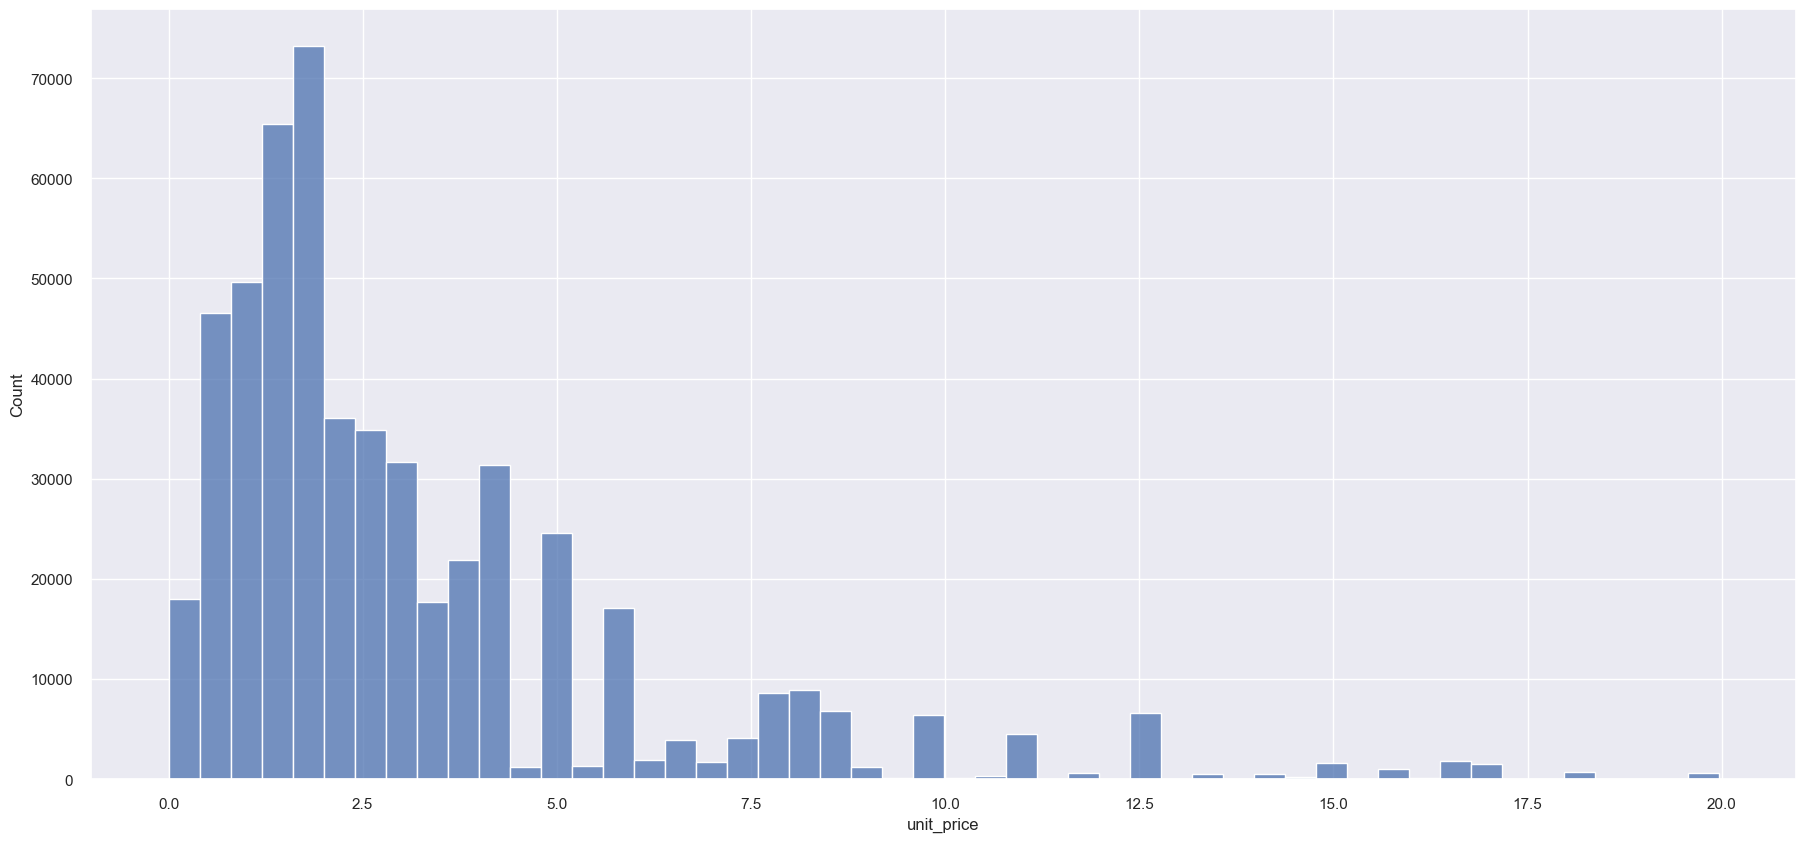

In [23]:
aux = df2[(df2['unit_price'] > 0) & (df2['unit_price'] < 20)]
sns.histplot(x='unit_price', bins=50, data=aux);

In [24]:
# remove unit_price bellow 0.030 (bellow this consider promo or return)
df2 = df2[df2['unit_price'] > 0.030]

# remove stock code with only categoricals variables (expect DCGSSBOY and DCGSSGIRL)
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 
                                    'm', 'PADS', 'B', 'CRUK'])]

# removes information from unidentified countries
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# bad users
df2 = df2[~df2['customer_id'].isin([16446])]

# separate dataframes for purchases and refunds
df2_purchases = df2[df2['quantity'] >= 0]
df2_returns = df2[df2['quantity'] < 0]

# 3.0 Feature Engineering

In [25]:
df3 = df2.copy()

Ideas
- Moving Average - 7d, 14d, 30d
- Quantidade de Compras por mês, antes do dia 15 e depois do dia 15
- Average Financial
- Criar feature de ratio da quatidade de devoluções por compras
- Analisar a feature e delimitar um valor máximo para realizar as exclusões

## 3.1 MindMap Hypothesis

## 3.2 Lista final de hipóteses

## 3.3 Feature Engineering

In [26]:
# -------------------- Features based on RFM Model ---------------
# make data frame for reference
df_ref = df3[['customer_id']].drop_duplicates(ignore_index=True)


# Gross Revenue (Faturamento) | quantity * price
df2_purchases['gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']


# Monetary - Total buys from each customer
df_monetary = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

In [27]:
# Recency - Last day purchase for each customer
df_recency = df2_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency.drop(columns=['invoice_date'], inplace=True)
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

In [28]:
# Quantity of purchased
df_qnt = (df2_purchases[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id')
                                             .count().reset_index()
                                             .rename(columns={'invoice_no': 'qty_invoices'}))

df_ref = pd.merge(df_ref, df_qnt, on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
dtype: int64

In [29]:
# Quantity of items purchased
df_qnt_items = (df2_purchases[['customer_id', 'quantity']].groupby('customer_id')
                                             .sum().reset_index()
                                             .rename(columns={'quantity': 'qty_items'}))

df_ref = pd.merge(df_ref, df_qnt_items, on='customer_id', how='left')

df_ref.isna().sum()                                             

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_items        91
dtype: int64

In [30]:
# Quantity of products purchased
df_qnt_products = (df2_purchases[['customer_id', 'stock_code']].groupby('customer_id')
                                             .count().reset_index()
                                             .rename(columns={'stock_code': 'qty_products'}))

df_ref = pd.merge(df_ref, df_qnt_products, on='customer_id', how='left')

df_ref.isna().sum()   

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_items        91
qty_products     91
dtype: int64

In [31]:
# Avg ticket - average purchases per customer
df_avg_ticket = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index()
df_avg_ticket.columns = ['customer_id', 'avg_ticket']
df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qty_invoices     91
qty_items        91
qty_products     91
avg_ticket       91
dtype: int64

In [32]:
# Mean of recency days
df_aux = df2_purchases[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[False, False])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # colect next customer id 
df_aux['next_invoice_date'] = df_aux['invoice_date'].shift() # colect next invoice date

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['next_invoice_date'] - x['invoice_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1) 

df_aux.drop(columns=['invoice_date', 'next_customer_id', 'next_invoice_date'], inplace=True)

# average recency
df_avg_recency = df_aux.dropna().groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge(df_ref, df_avg_recency, how='left', on='customer_id')

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_items             91
qty_products          91
avg_ticket            91
avg_recency_days    3013
dtype: int64

In [33]:
# Frequency - total number of purchases in a period
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates().groupby('customer_id')
                                                            .agg(max_ = ('invoice_date', 'max'), min_ = ('invoice_date', 'min'), 
                                                                days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1), 
                                                                buy_ = ('invoice_no', 'count') ).reset_index())

# Calculate frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], how='left', on='customer_id')

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_items             91
qty_products          91
avg_ticket            91
avg_recency_days    3013
frequency             91
dtype: int64

In [34]:
# Number of returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qtd_returns'})
df_returns['qtd_returns'] = df_returns['qtd_returns'] * -1

# Merge
df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['qtd_returns'].isna(), 'qtd_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_items             91
qty_products          91
avg_ticket            91
avg_recency_days    3013
frequency             91
qtd_returns            0
dtype: int64

In [35]:
# Basket Size (Quantity)
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                         .agg(n_purchase=('invoice_no', 'nunique'), 
                                                         n_products=('quantity', 'sum')).reset_index())

# calculate basket size
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id')

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qty_invoices          91
qty_items             91
qty_products          91
avg_ticket            91
avg_recency_days    3013
frequency             91
qtd_returns            0
avg_basket_size       91
dtype: int64

In [36]:
# Unique Basket Size
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                         .agg(n_purchase=('invoice_no', 'nunique'), 
                                                         n_products=('stock_code', 'nunique')).reset_index())

# calculate basket size
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id')

df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qty_invoices                91
qty_items                   91
qty_products                91
avg_ticket                  91
avg_recency_days          3013
frequency                   91
qtd_returns                  0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

In [37]:
df_ref = df_ref.dropna()
df_ref.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qty_invoices              0
qty_items                 0
qty_products              0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtd_returns               0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

# 4.0 Análise exploratória dos dados

**Ideas**

- Analise de Cohort

In [38]:
df4 = df_ref.copy()

In [39]:
df4.to_csv('../data/interim/df4.csv', index=False)

## 4.1 Análise Univariada

1. Clusters Coesos - Separados
2. Métricas
    - Min, Max, Range
    - Media, Mediana
    - Desvio padrão e variância
    - Coeficiente de variação (CV)
    - Distribuição

In [40]:
#profile = ProfileReport(df4)
#profile.to_file('../reports/output_v1.html')

### 4.1.1 Gross revenue

In [41]:
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id


- Remover o cliente

### 4.1.2 Quantity of items

In [42]:
df4[df4['qty_items'] == 196844]

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items,qty_products,avg_ticket,avg_recency_days,frequency,qtd_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.020,1.000,72.000,196844.000,2060.000,135.504,8.023,0.203,288.000,2733.944,9.708


### 4.1.3 Quantity of products

In [43]:
df4[df4['qty_products'] == 7838]

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items,qty_products,avg_ticket,avg_recency_days,frequency,qtd_returns,avg_basket_size,avg_unique_basket_size
68,17841,40967.720,1.000,124.000,23053.000,7838.000,5.227,3.351,0.332,203.000,185.911,10.661


### 4.1.4 Average ticket/ Quantity of returns

In [44]:
df4[df4['avg_ticket'] == 4453.43]

,customer_id,gross_revenue,recency_days,qty_invoices,qty_items,qty_products,avg_ticket,avg_recency_days,frequency,qtd_returns,avg_basket_size,avg_unique_basket_size
1262,15749,44534.300,235.000,3.000,18028.000,10.000,4453.430,97.000,0.031,9014.000,6009.333,1.667


In [45]:
df3[df3['customer_id'] == 15749]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
52709,540815,85123A,1930,2017-01-09,2.550,United Kingdom,15749
52710,540815,21175,2000,2017-01-09,1.850,United Kingdom,15749
52711,540815,21108,3114,2017-01-09,2.100,United Kingdom,15749
52771,540818,47556B,1300,2017-01-09,2.550,United Kingdom,15749
52772,540818,48185,670,2017-01-09,6.750,United Kingdom,15749
160141,C550456,48185,-670,2017-04-16,6.750,United Kingdom,15749
160142,C550456,47566B,-1300,2017-04-16,2.550,United Kingdom,15749
160143,C550456,85123A,-1930,2017-04-16,2.550,United Kingdom,15749
160144,C550456,21175,-2000,2017-04-16,1.850,United Kingdom,15749
160145,C550456,21108,-3114,2017-04-16,2.100,United Kingdom,15749


- Remover compras duplicadas do cliente

## 4.2 Análise Bivariada

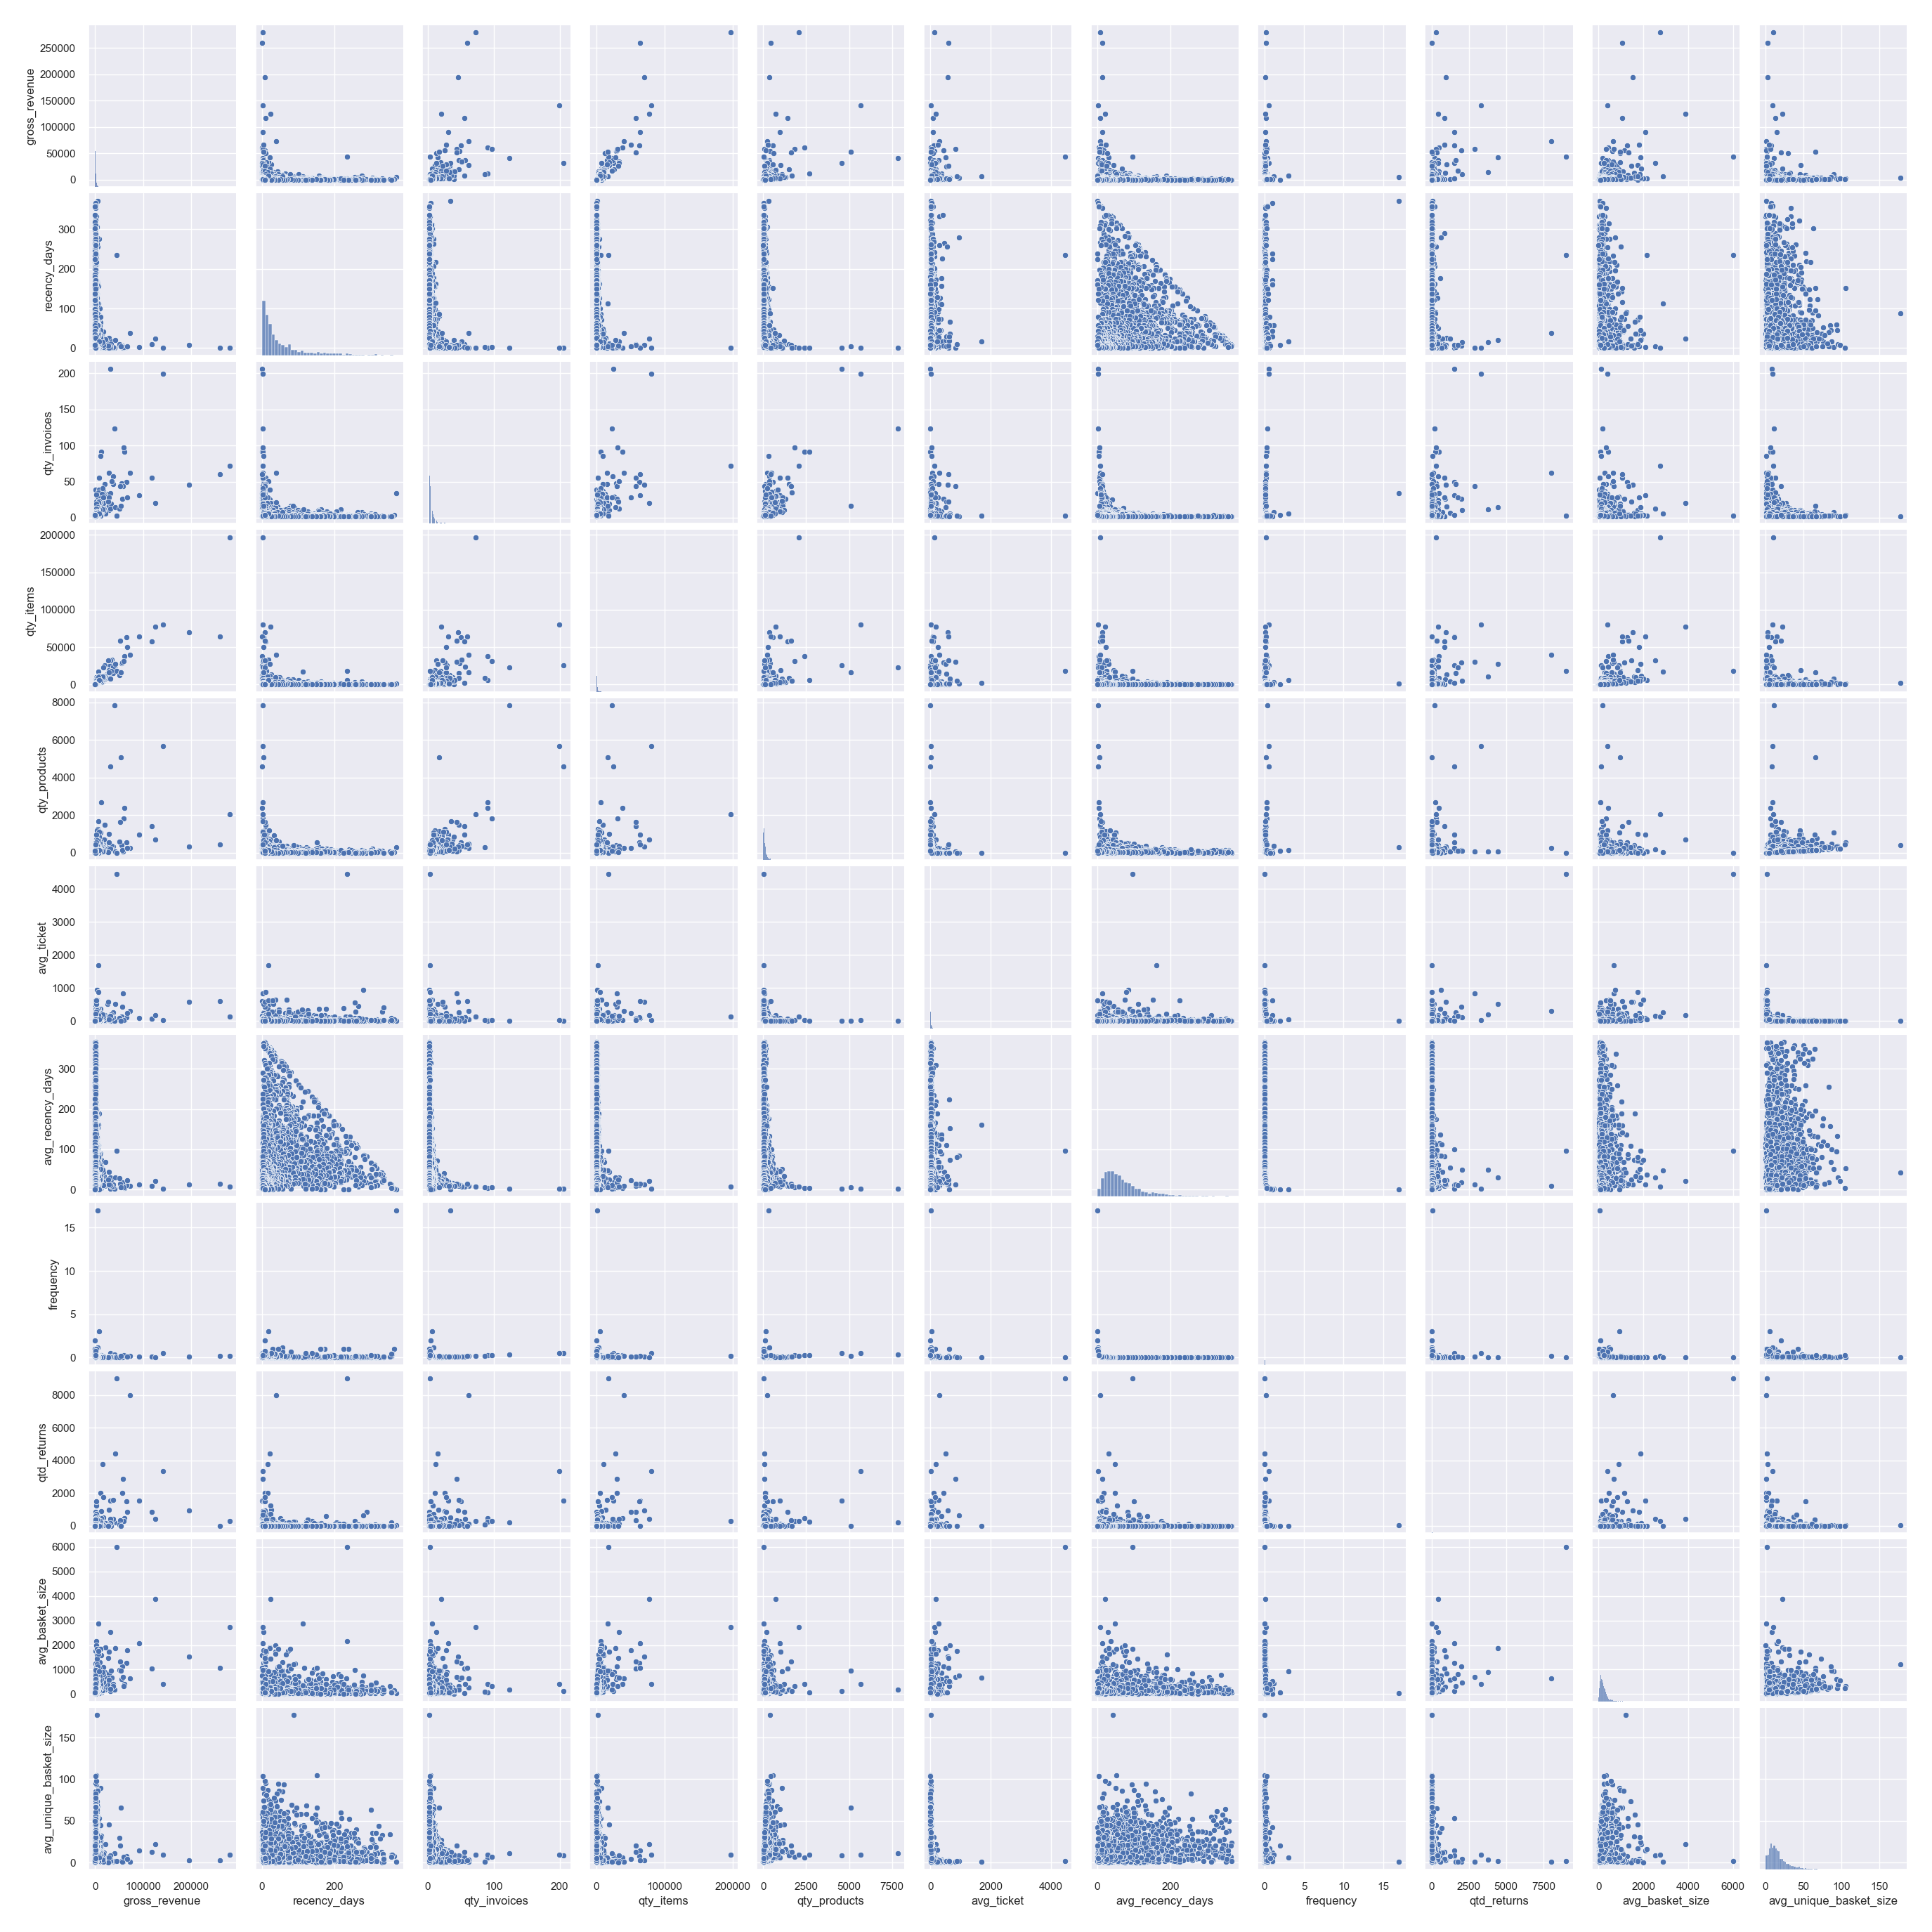

In [46]:
#cols = ['customer_id']
#df42 = df4.drop(cols, axis=1)

#plt.figure(figsize=(25,12))
#sns.pairplot(df42);
#plt.savefig('../reports/pairplot-c4.1_v2.png')

Image('../reports/pairplot-c4.1_v2.png')

- Frequency has low variancy
- Avg ticket has low variancy

## 4.3 Estudo do espaço

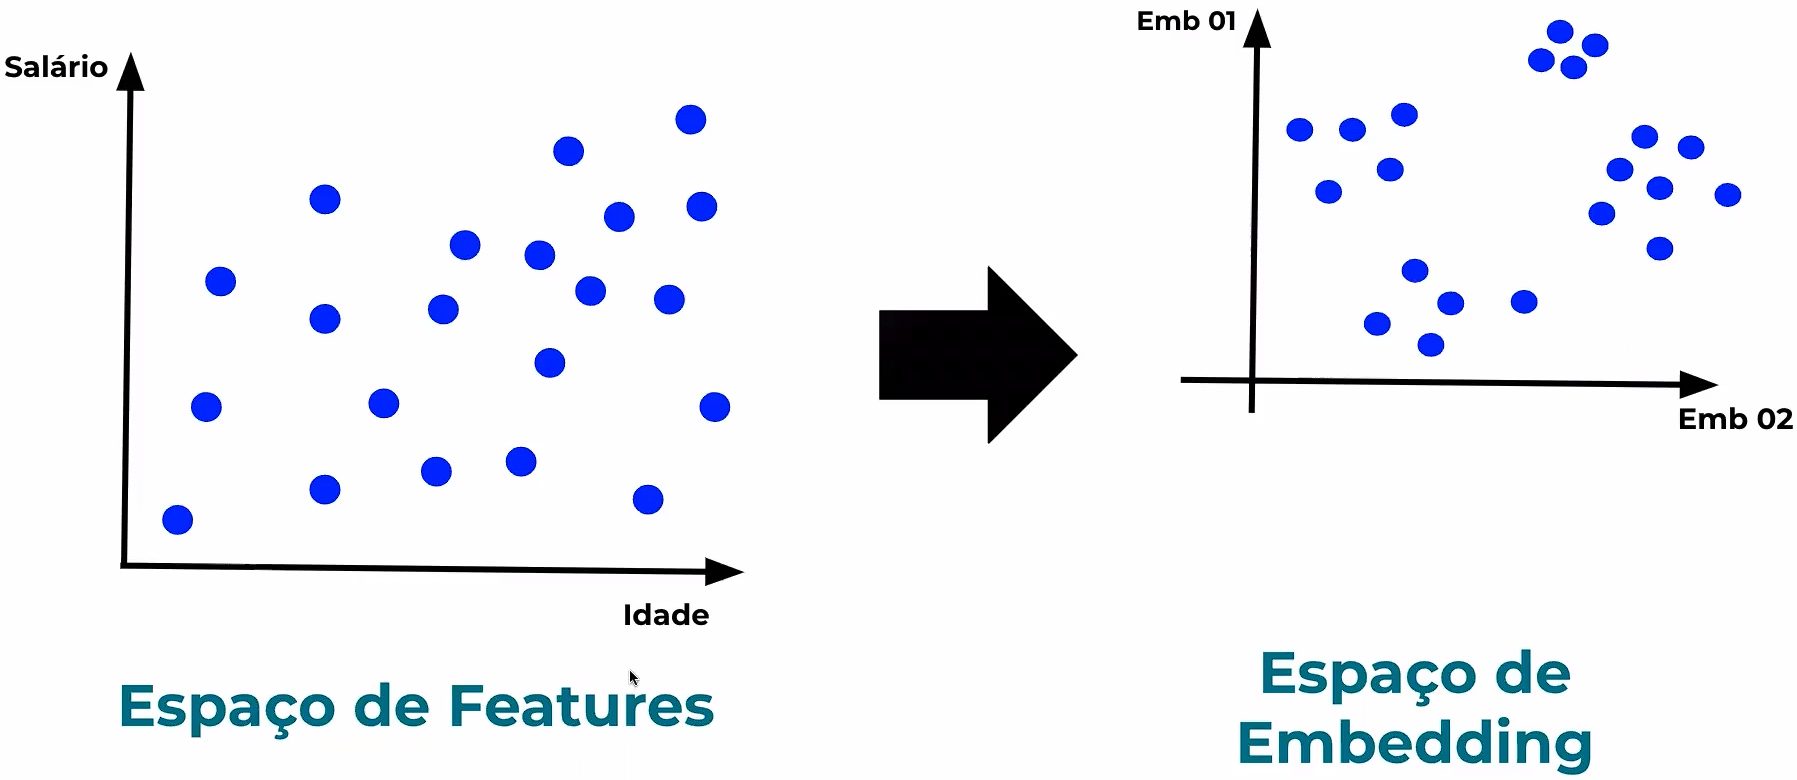

In [47]:
Image('../references/espaco_embedding.png')

In [48]:
df43 = df4.drop(columns=['customer_id'], axis=1).copy()

# Make rescaling for data organization analysis
mms = pp.MinMaxScaler()

df43['gross_revenue'] = mms.fit_transform(df43[['gross_revenue']].values)
df43['qty_invoices'] = mms.fit_transform(df43[['qty_invoices']].values)
df43['recency_days'] = mms.fit_transform(df43[['recency_days']].values)
df43['qty_items'] = mms.fit_transform(df43[['qty_items']].values)
df43['qty_products'] = mms.fit_transform(df43[['qty_products']].values)
df43['avg_ticket'] = mms.fit_transform(df43[['avg_ticket']].values)
df43['avg_recency_days'] = mms.fit_transform(df43[['avg_recency_days']].values)
df43['frequency'] = mms.fit_transform(df43[['frequency']].values)
df43['qtd_returns'] = mms.fit_transform(df43[['qtd_returns']].values)
df43['avg_basket_size'] = mms.fit_transform(df43[['avg_basket_size']].values)
df43['avg_unique_basket_size'] = mms.fit_transform(df43[['avg_unique_basket_size']].values)

X = df43.copy()

### 4.3.1 PCA

In [49]:
X.shape[1]

11

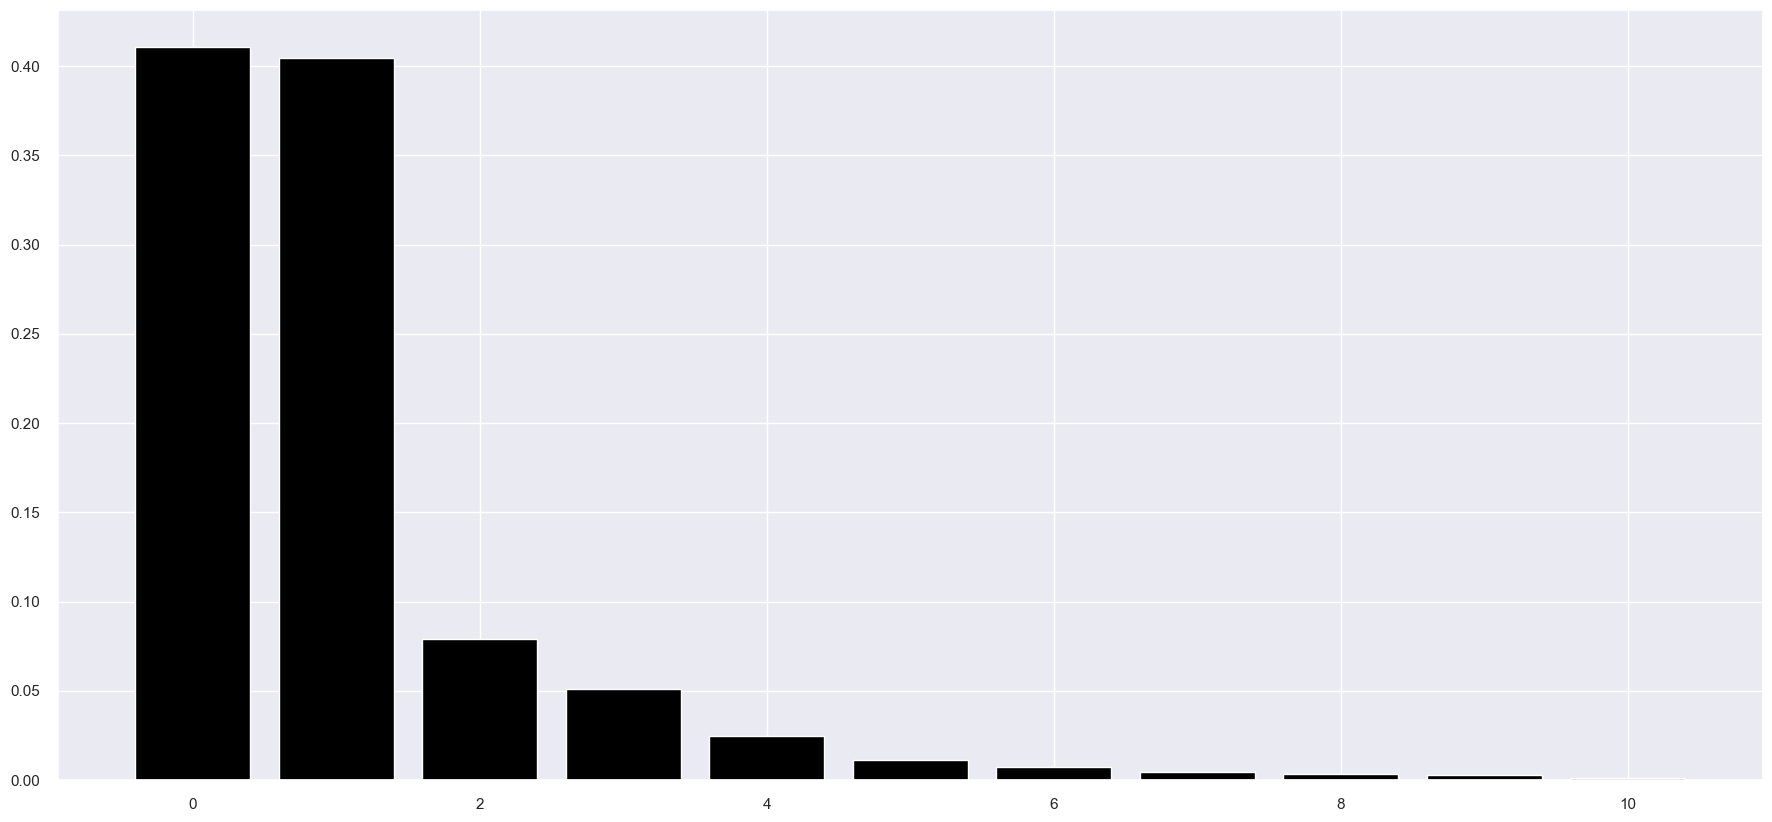

In [50]:
pca = dd.PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black');

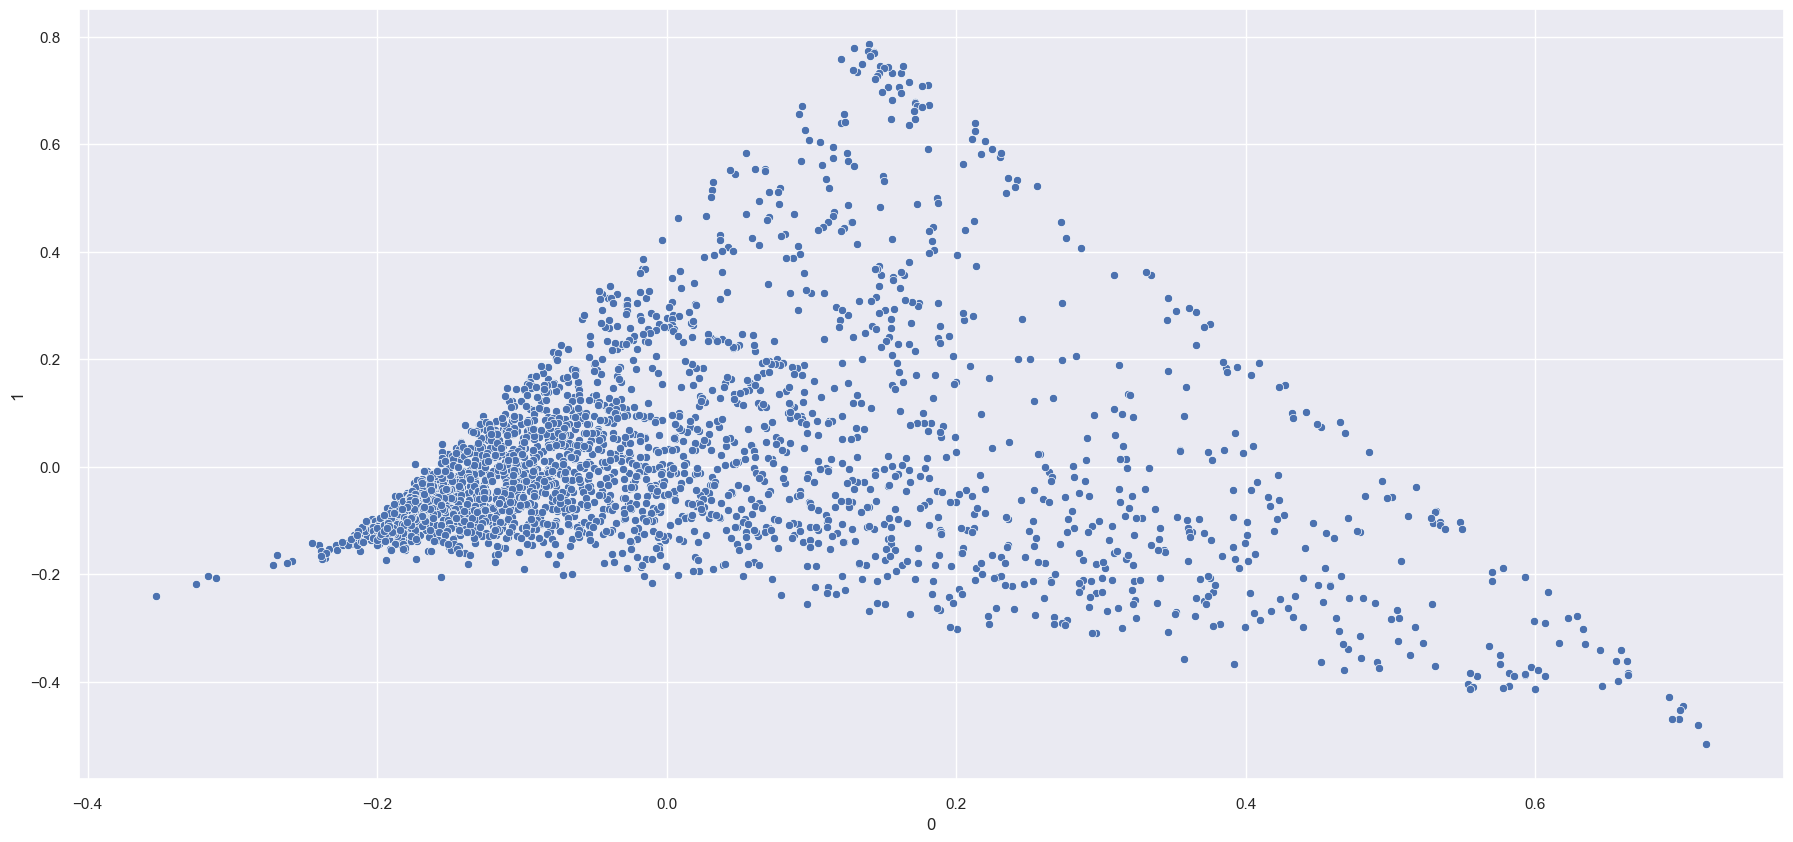

In [51]:
# pca component
df_pca = pd.DataFrame(principal_components)

sns.scatterplot(x=0, y=1, data=df_pca);

### 4.3.2 UMAP

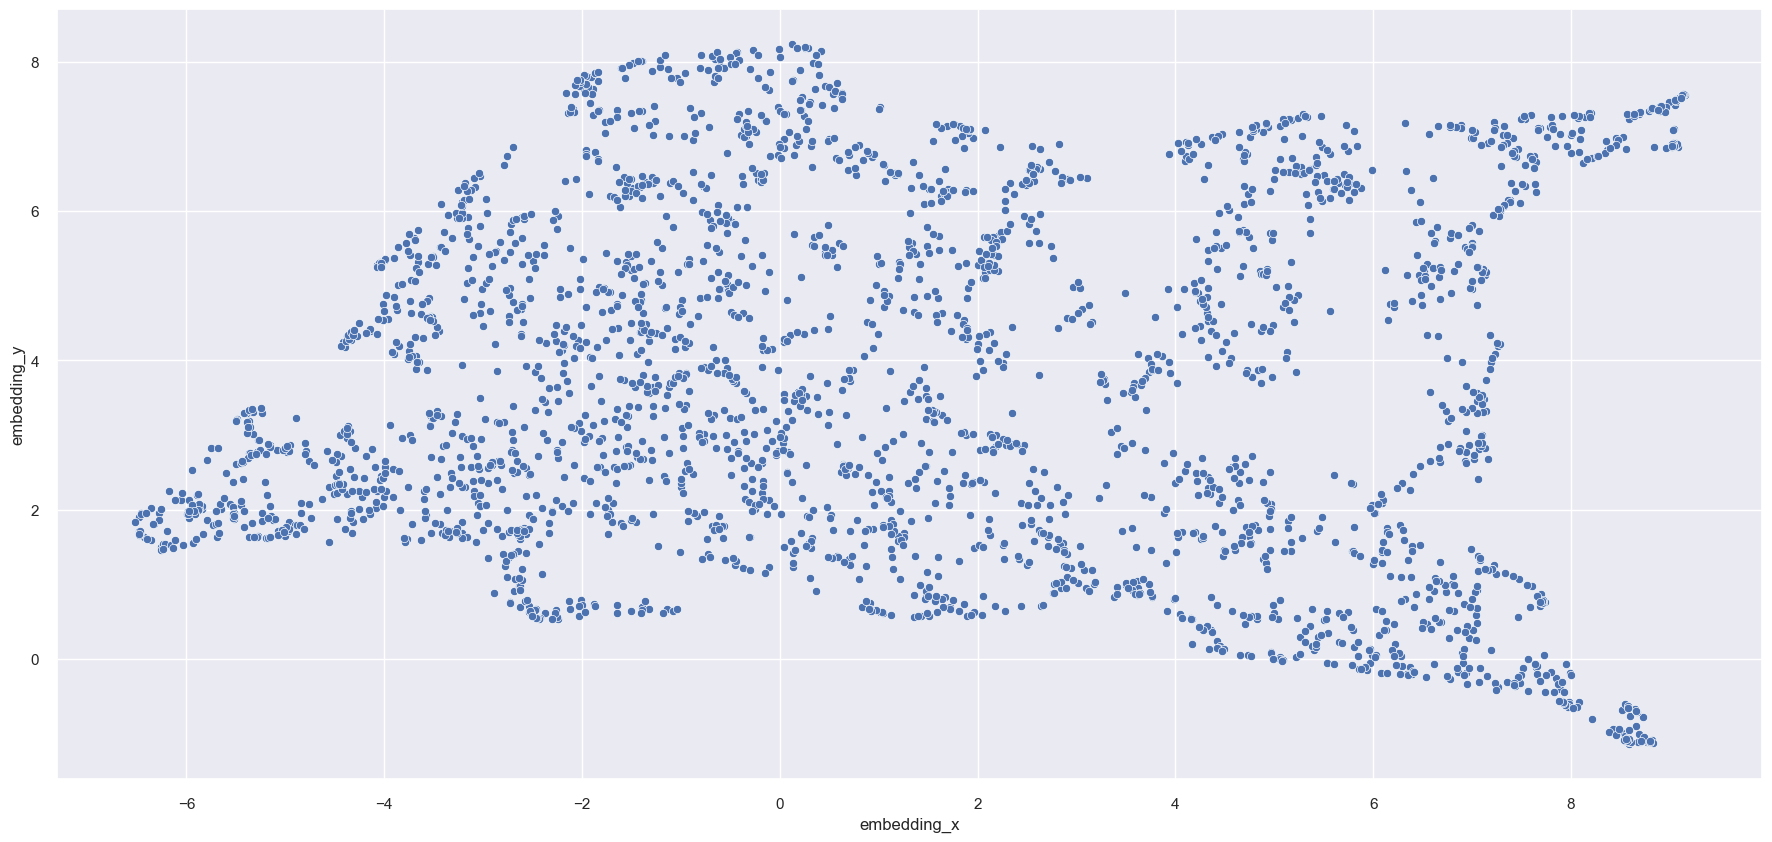

In [52]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# Embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:,0]
df_umap['embedding_y'] = embedding[:,1]

# Plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_umap);

### 4.3.3 t-SNE

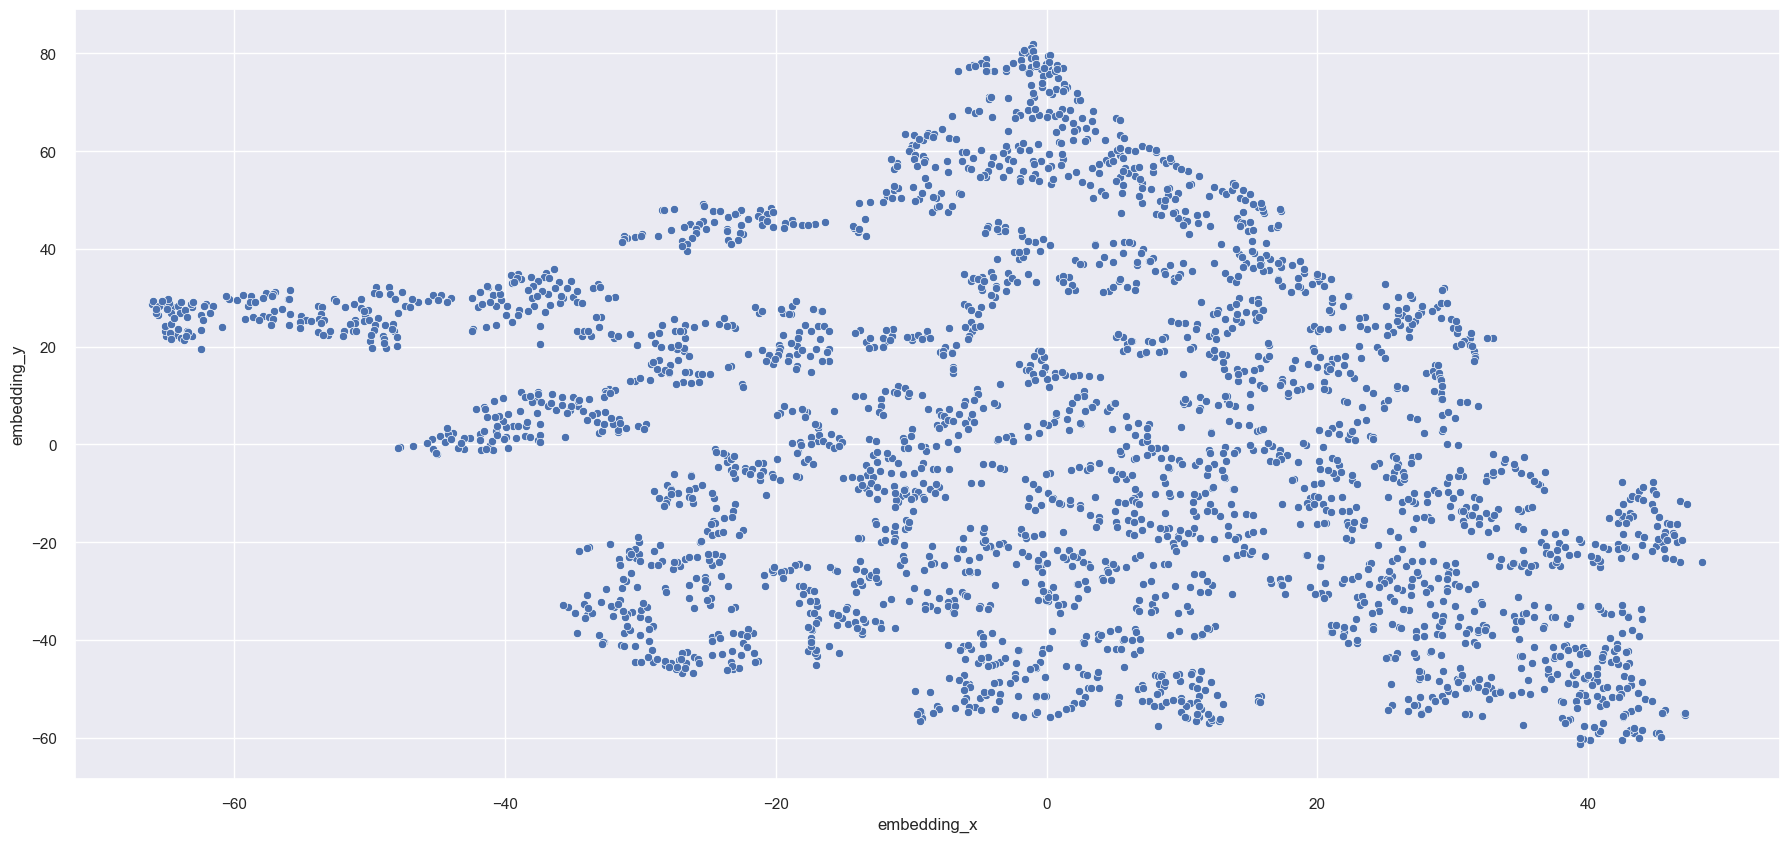

In [53]:
reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

# Embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:,0]
df_tsne['embedding_y'] = embedding[:,1]

# Plot t-SNE
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tsne);

### 4.3.4 Tree-based Embedding

**Notes**
- Boruta para seleção de features
- Fine tunning

In [54]:
# training dataset
X = df4.drop(columns=['customer_id', 'gross_revenue'], axis=1)
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)

# make dataframe for leaf
df_leaf = pd.DataFrame(rf_model.apply(X))

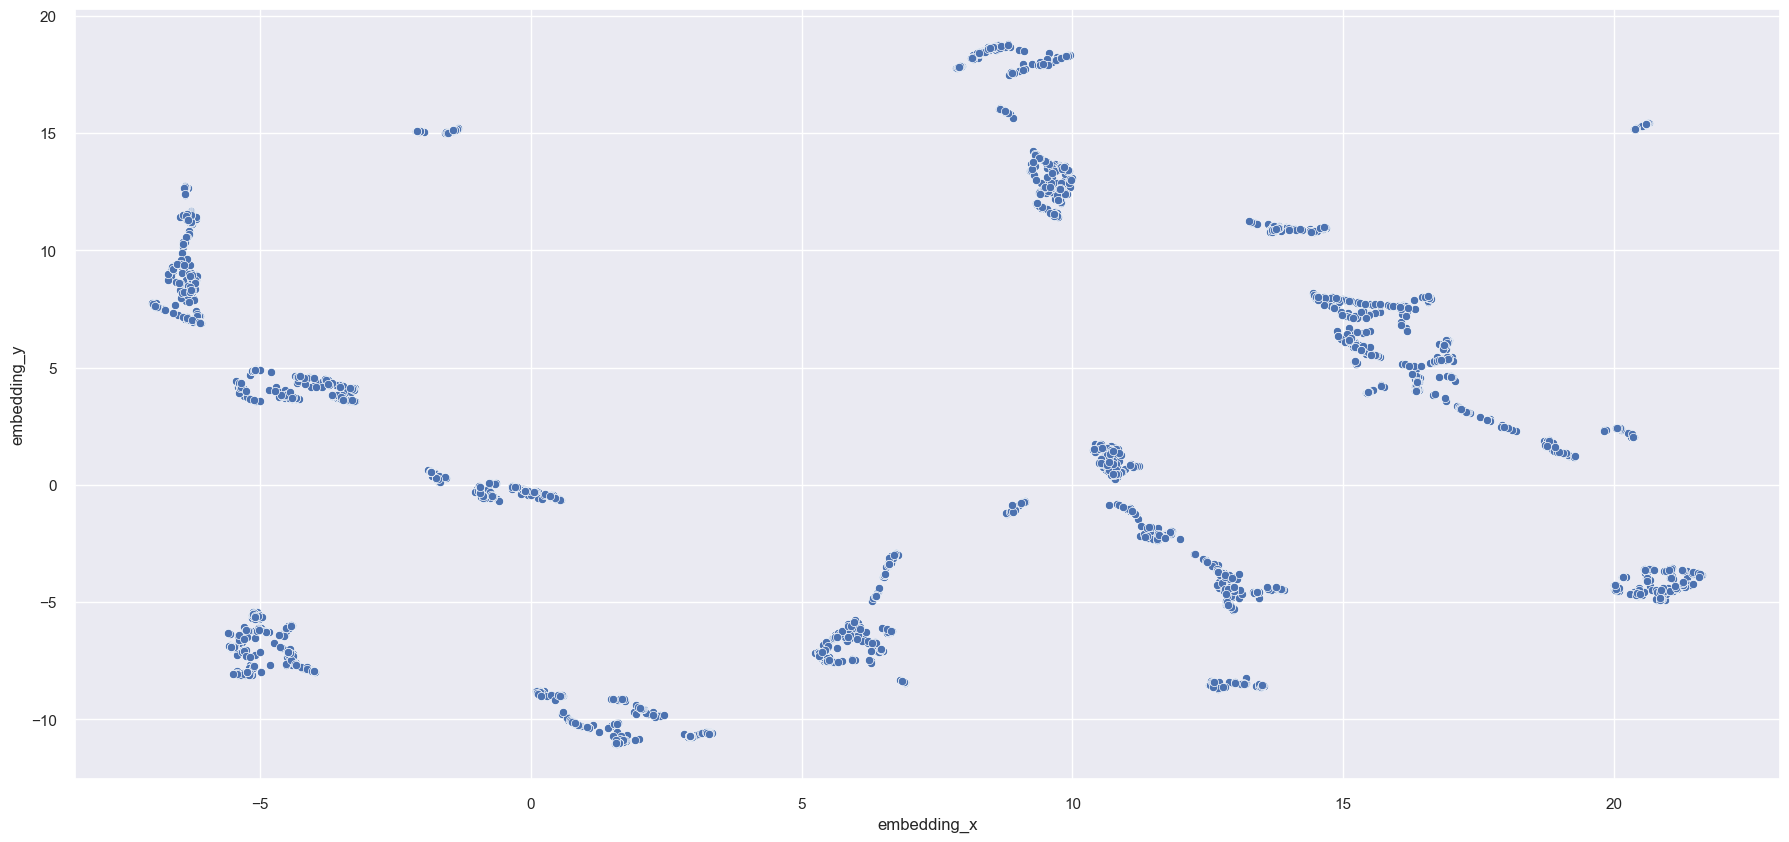

In [55]:
# reducer dimensionality
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# Embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:,0]
df_tree['embedding_y'] = embedding[:,1]

# Plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree);

# 5.0 Preparação dos dados

In [56]:
#df5 = df4.copy()

## 5.1 Rescaling

In [57]:
# mms = pp.MinMaxScaler()

# df5['gross_revenue'] = mms.fit_transform(df5[['gross_revenue']].values)
# df5['qty_invoices'] = mms.fit_transform(df5[['qty_invoices']].values)
# df5['recency_days'] = mms.fit_transform(df5[['recency_days']].values)
# df5['qty_items'] = mms.fit_transform(df5[['qty_items']].values)
# df5['qty_products'] = mms.fit_transform(df5[['qty_products']].values)
# df5['avg_ticket'] = mms.fit_transform(df5[['avg_ticket']].values)
# df5['avg_recency_days'] = mms.fit_transform(df5[['avg_recency_days']].values)
# df5['frequency'] = mms.fit_transform(df5[['frequency']].values)
# df5['qtd_returns'] = mms.fit_transform(df5[['qtd_returns']].values)
# df5['avg_basket_size'] = mms.fit_transform(df5[['avg_basket_size']].values)
# df5['avg_unique_basket_size'] = mms.fit_transform(df5[['avg_unique_basket_size']].values)

# 6.0 Feature Selection

In [58]:
#df6 = df5.copy()

# 7.0 Hyper Parameter Fine Tunning

In [60]:
# drop customer id for ML train
X = df_tree.copy()
X

,embedding_x,embedding_y
0,-1.837,0.561
1,-5.014,-5.743
2,-6.398,10.351
3,20.119,2.443
4,9.679,11.520
...,...,...
2768,20.476,-4.640
2769,12.945,-3.981
2770,11.054,0.839
2771,13.761,-4.380


In [61]:
# make search space for clusters
clusters = np.arange(2, 25, 1)

## 7.1 K-Means

In [62]:
kmeans_list = []
for k in clusters:
    # Model definition
    kmeans_model = c.KMeans(n_clusters=k)

    # Model training
    kmeans_model.fit(X)

    # Model predict
    labels = kmeans_model.predict(X)

    # Model performance
    sil = m.silhouette_score(X, labels)
    kmeans_list.append(sil)

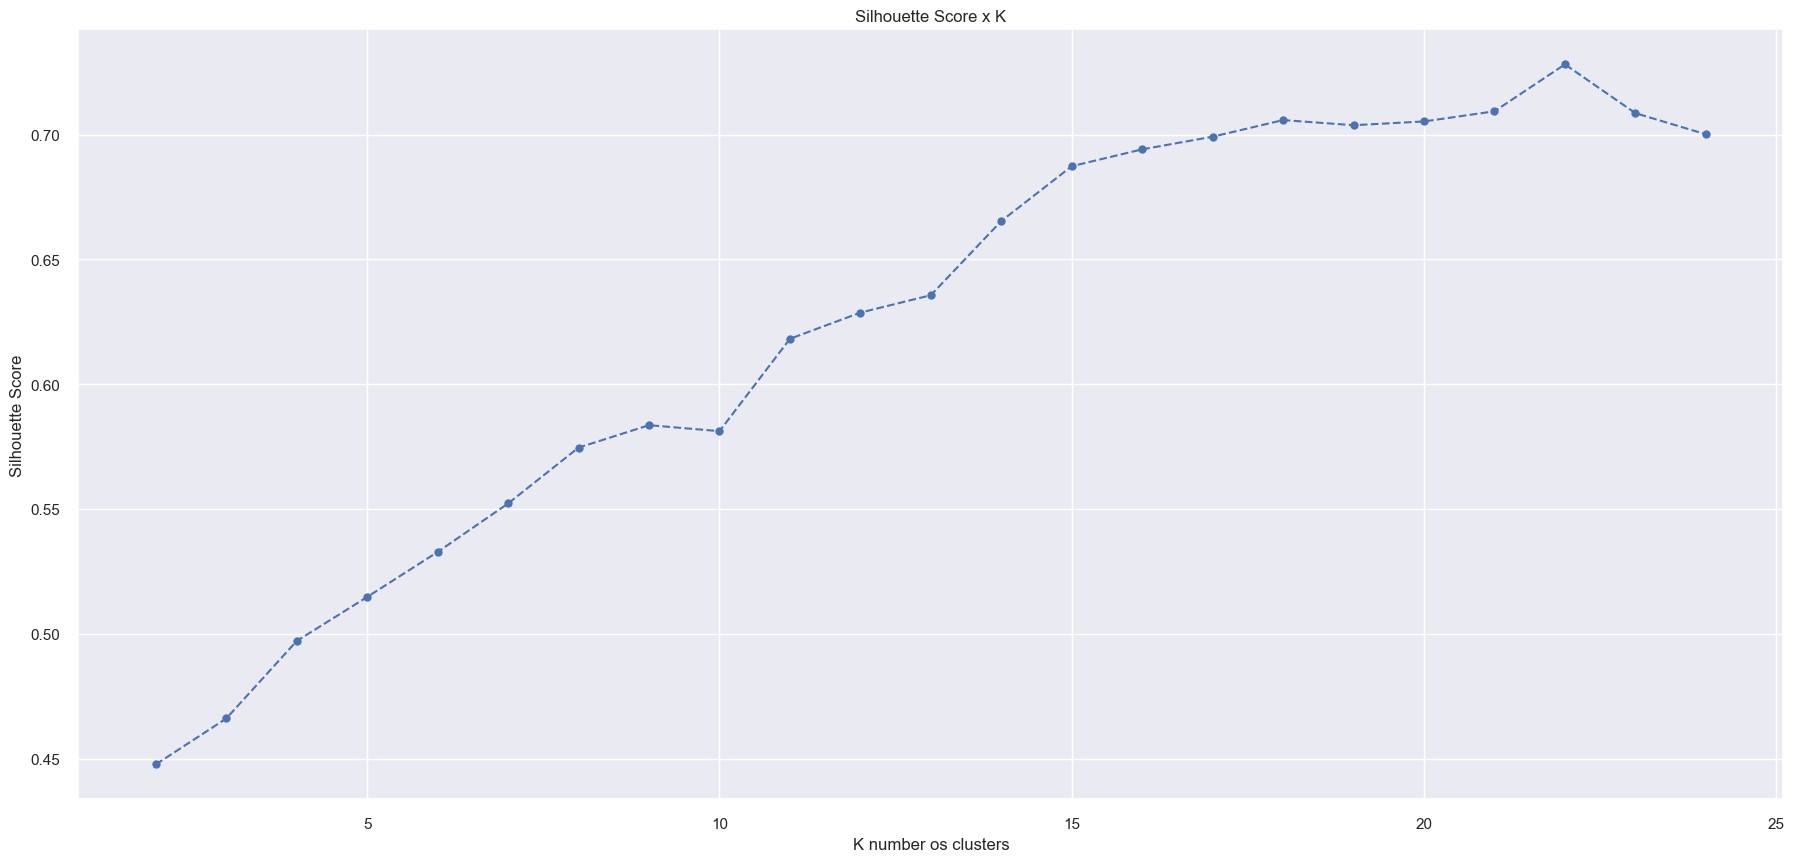

In [63]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('K number os clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score x K');

## 7.2 Gaussian Mixture Model (GMM)

In [64]:
gmm_list = []
for k in clusters:
    # Model definition
    gmm_model = mx.GaussianMixture(n_components=k)
    # Model training
    gmm_model.fit(X)

    # Model predict
    labels = gmm_model.predict(X)

    # Model performance
    sil = m.silhouette_score(X, labels)
    gmm_list.append(sil)

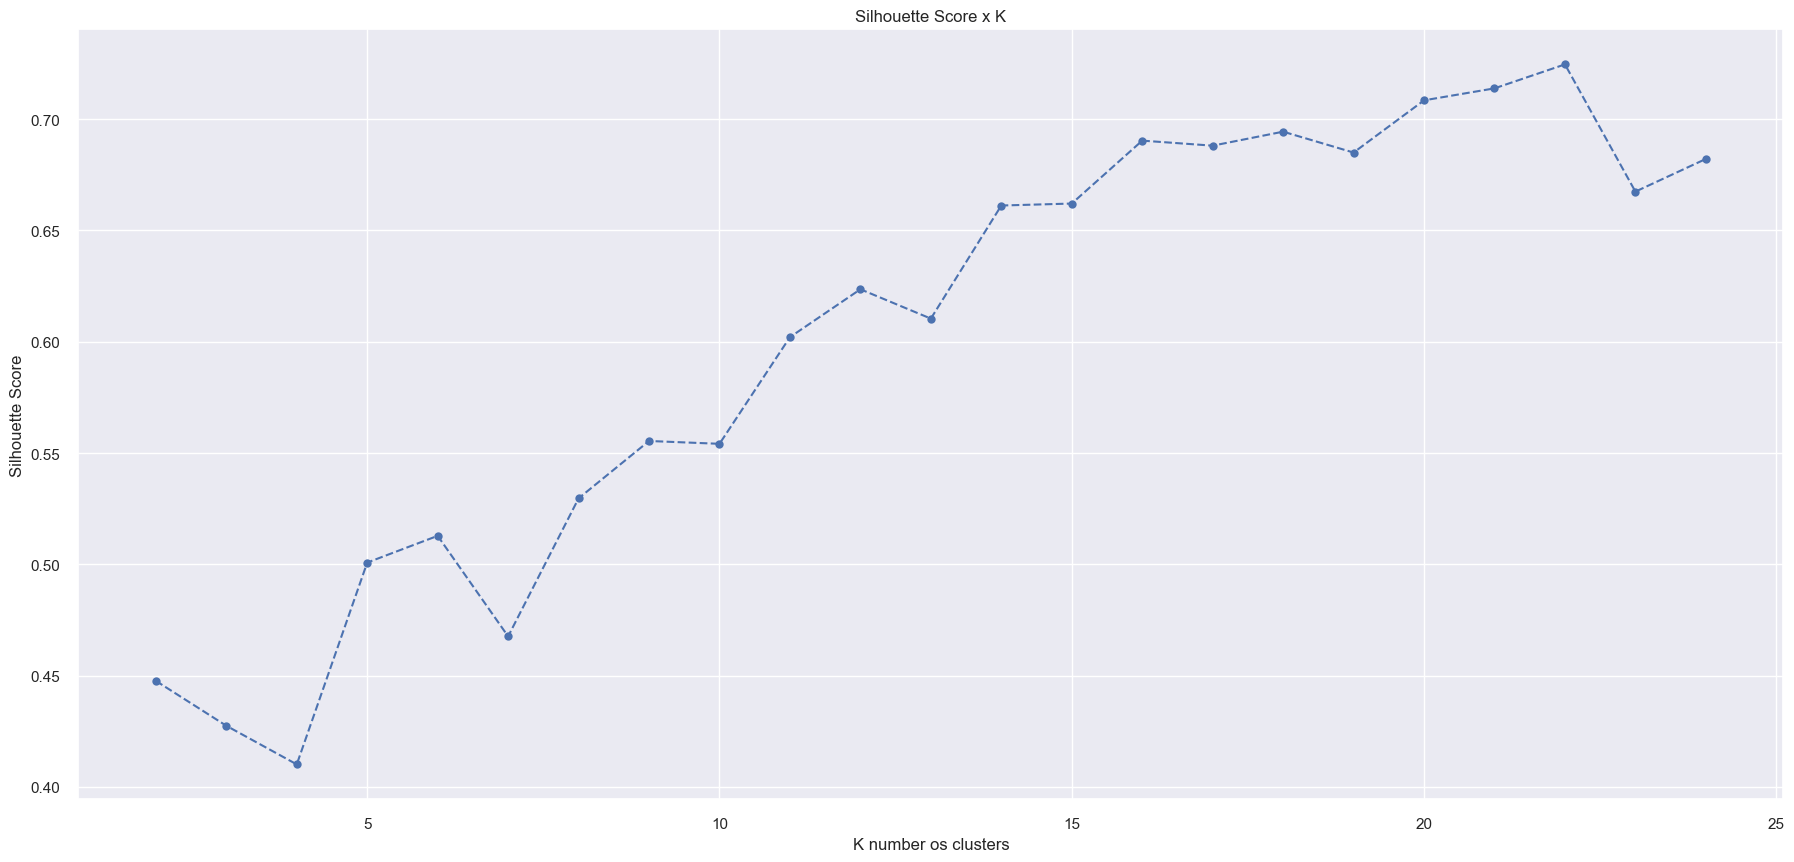

In [65]:
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('K number os clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score x K');

## 7.3 Hierarchical Clustering

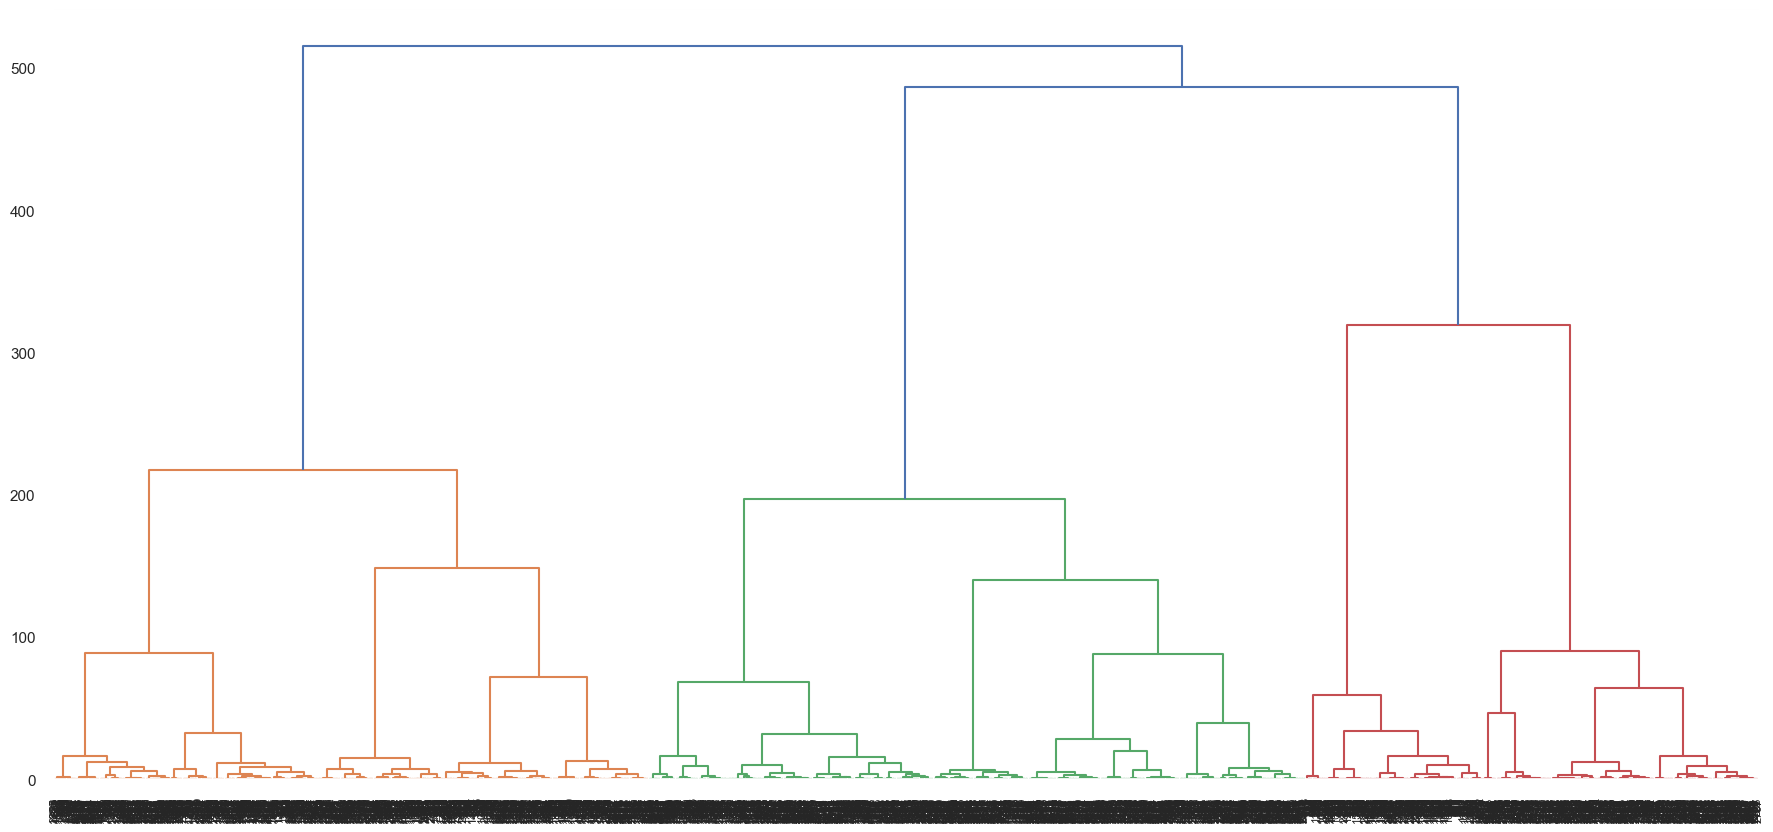

In [66]:
# model definition and training
hc_model = hc.linkage(X, 'ward')

# plot of dendrogram
hc.dendrogram(hc_model, leaf_rotation=90, leaf_font_size=8)

plt.plot();

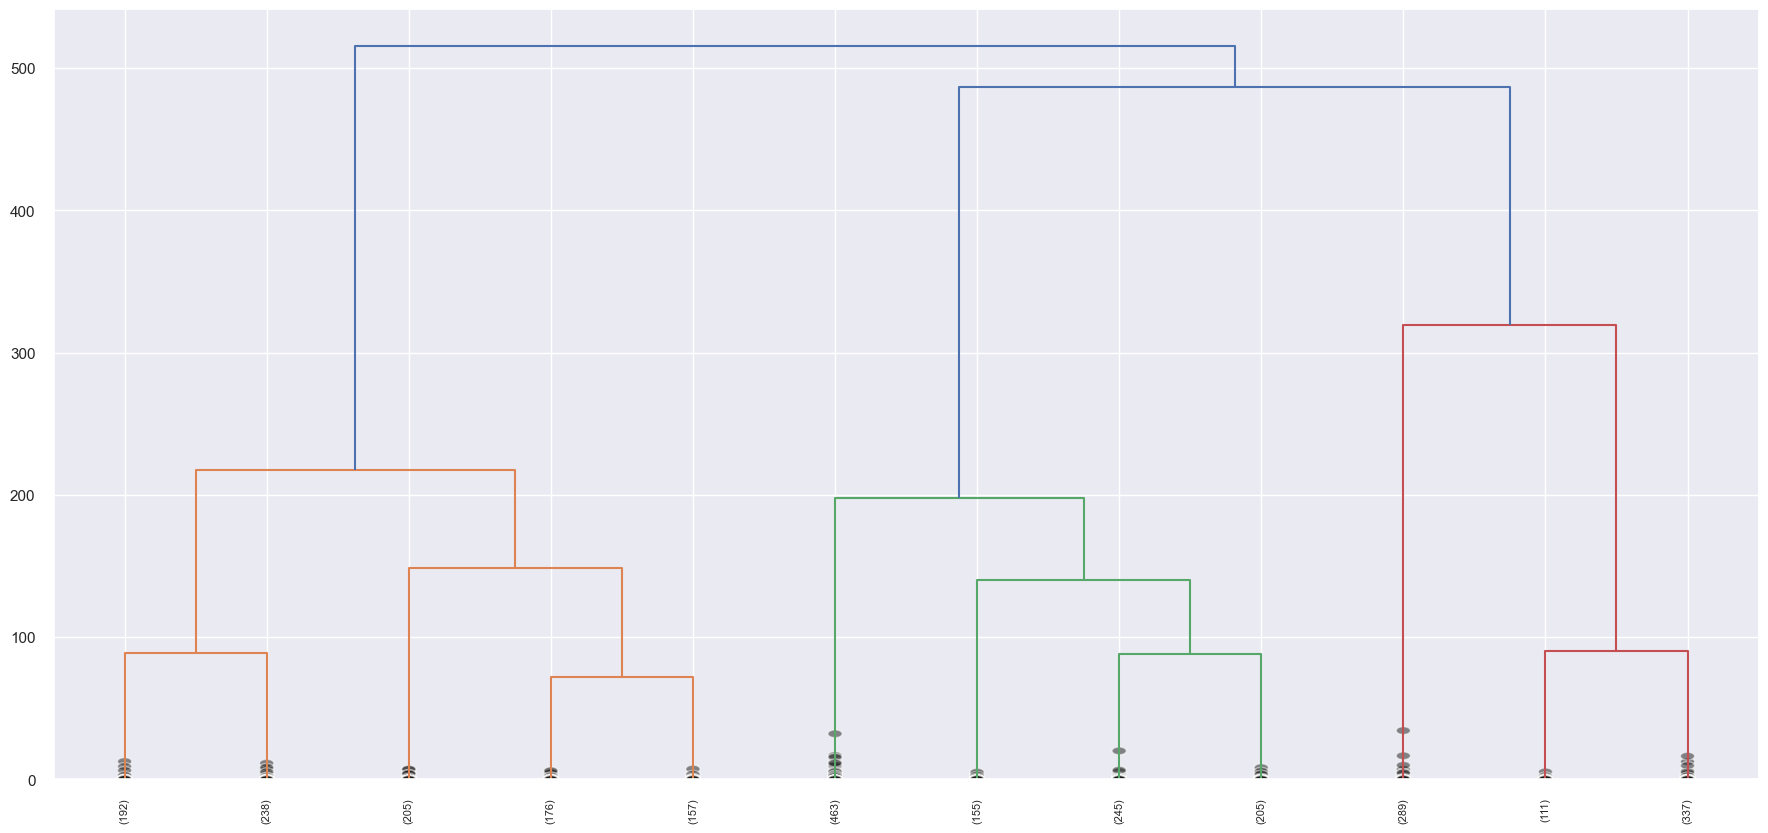

In [67]:
# truncate plot of dendrogram
hc.dendrogram(hc_model, truncate_mode='lastp', p=12, leaf_rotation=90, leaf_font_size=8, show_contracted=True)

plt.plot();

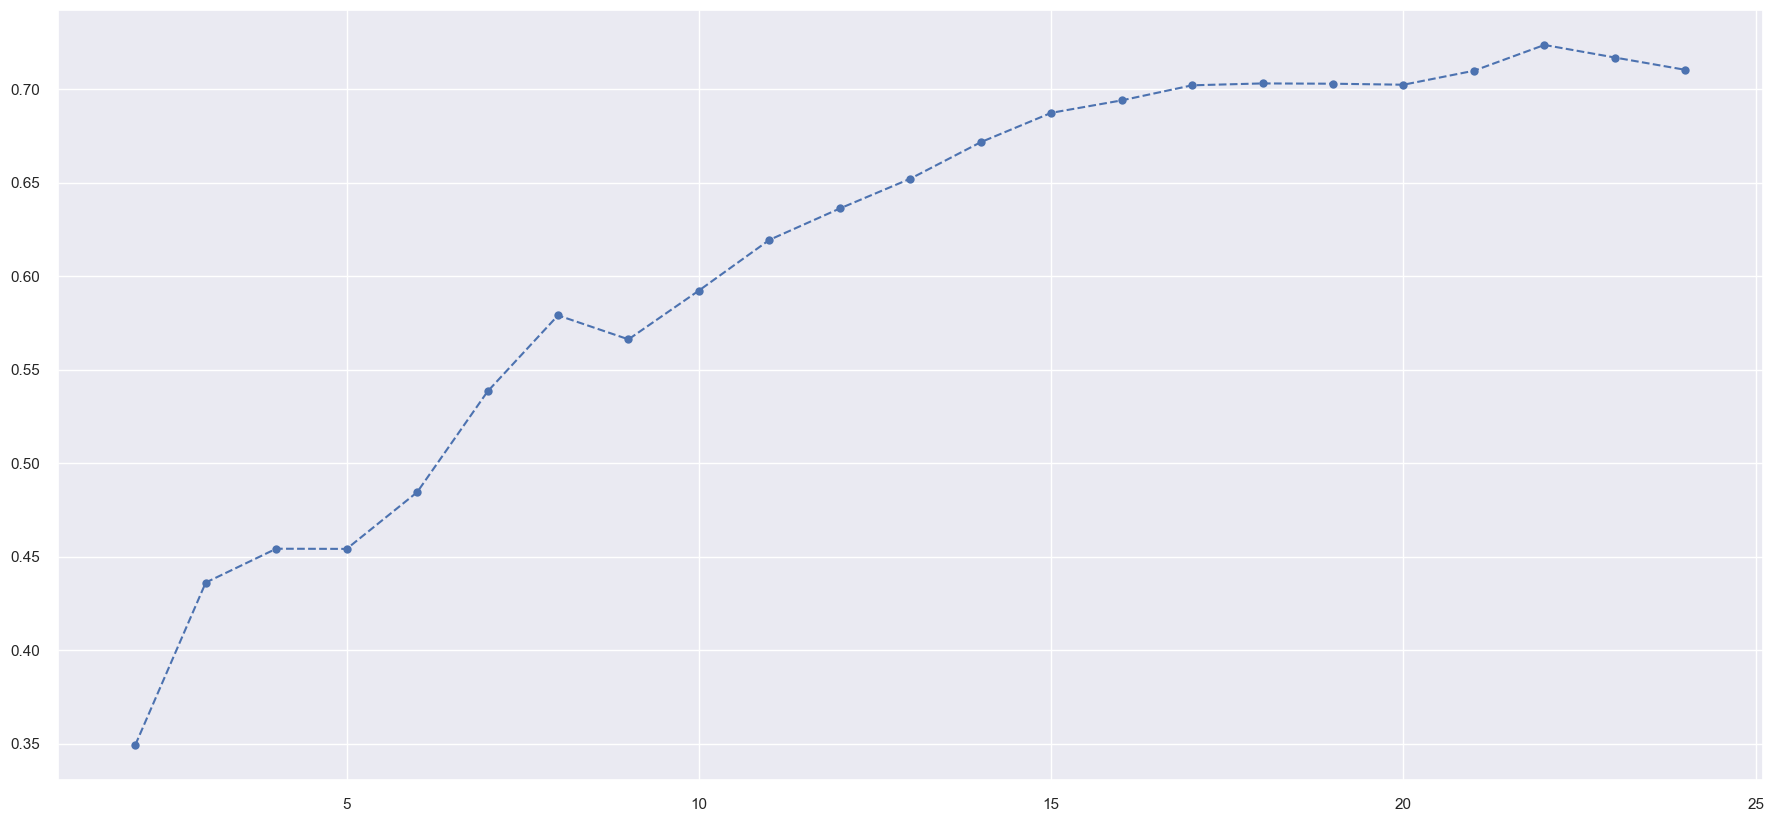

In [68]:
# Silhouette Score
hc_list = []
for k in clusters:
    # Model definition & training
    hc_model = hc.linkage(X, 'ward')

    # Model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # Metrics
    sil = m.silhouette_score(X, labels)
    hc_list.append(sil)

plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b');

## 7.4 DBScan

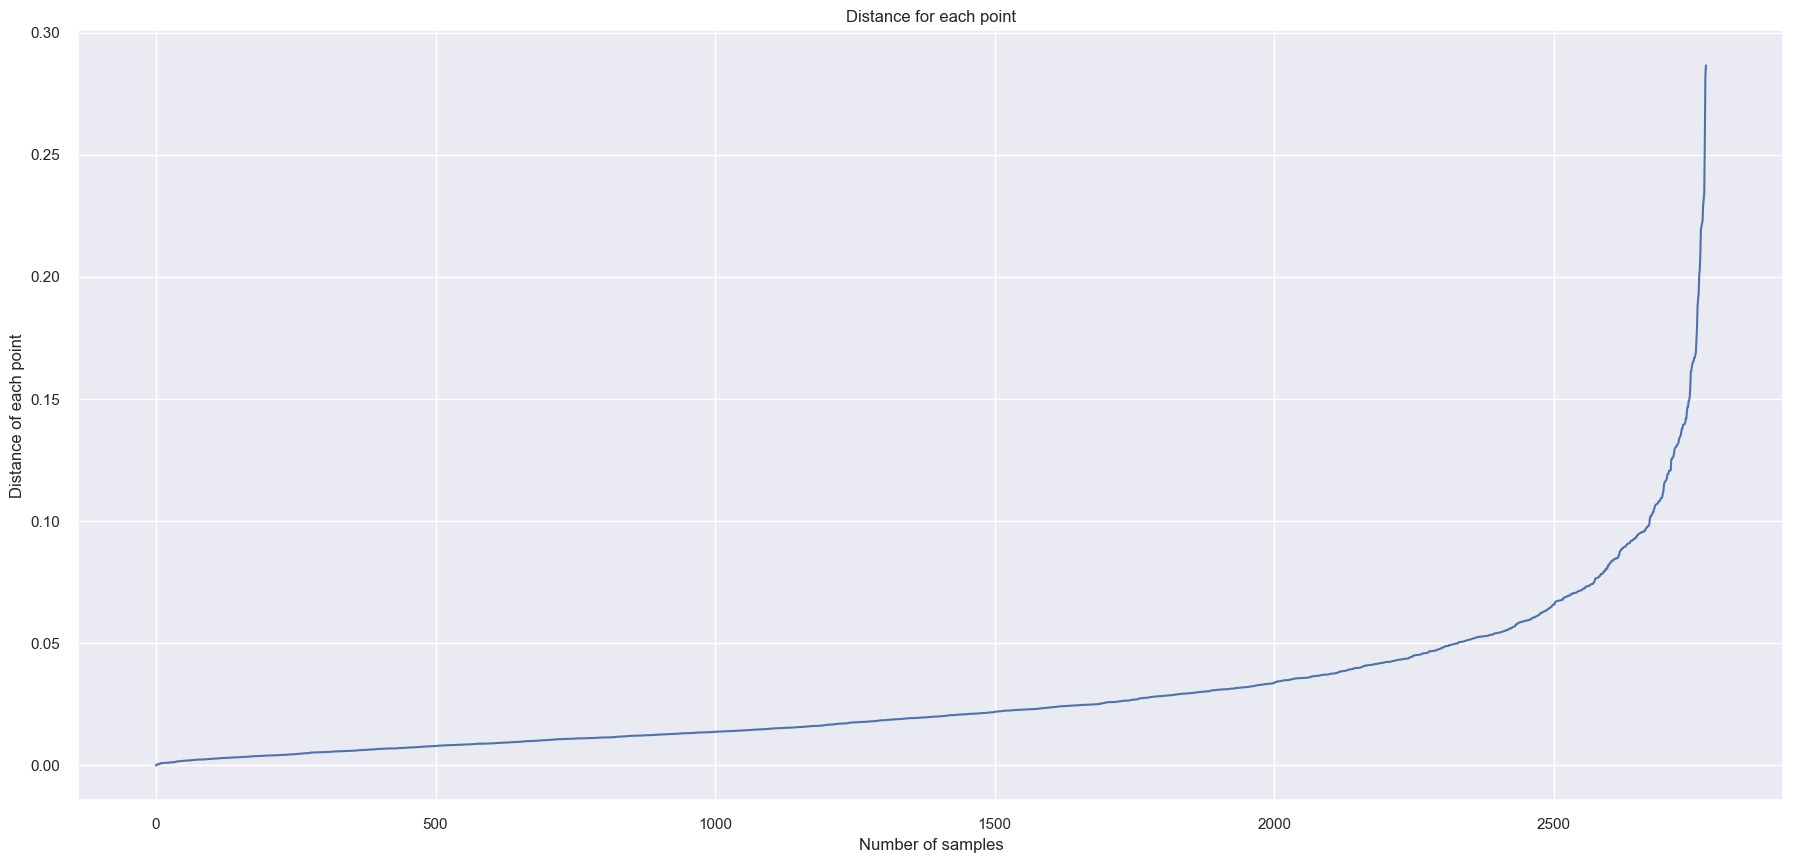

In [95]:
# Search space parameters
eps=0.8
min_samples = 40

# using nearest model for find number os neighbors for dbscan
neighbors = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances, index = neighbors.kneighbors(X)

distances = np.sort(distances, axis=0)

plt.plot(distances[:,1])
plt.title('Distance for each point')
plt.xlabel('Number of samples')
plt.ylabel('Distance of each point');

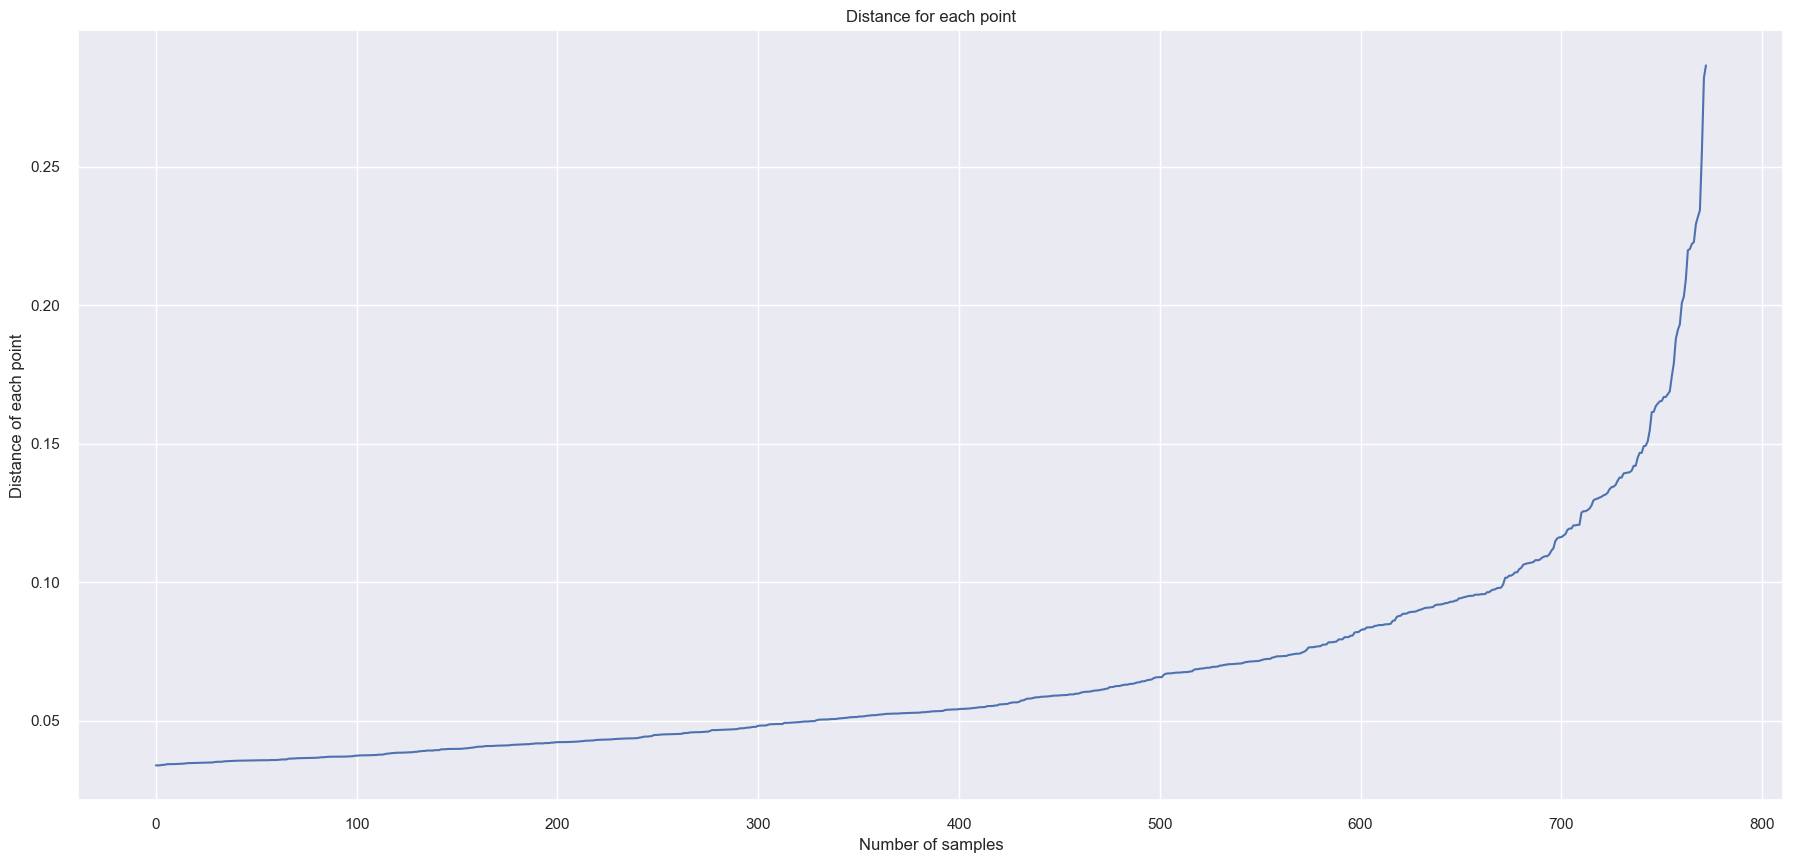

In [76]:
# Make zoom into graph
plt.plot(distances[2000:,1])
plt.title('Distance for each point')
plt.xlabel('Number of samples')
plt.ylabel('Distance of each point');

In [96]:
# model definition
dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples)

# model training and predict
labels = dbscan_model.fit_predict(X)

sil = m.silhouette_score(X, labels)
print(f'Silhouette Score: {sil}')
print(f'Number of clusters: {np.unique(labels)}')


Silhouette Score: 0.6009425520896912
Number of clusters: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


In [ ]:
# list for metrics result
dbscan_list = [0.605918, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## 7.5 Results 

In [72]:
# Model Name | k=2 | k=3 | k=4 | k=5 | ...
#  Kmeans      SS    SS    SS    SS
#  GMM         SS    SS    SS    SS
#  HC         SS     SS    SS    SS
#  DBSCAN     SS    SS    SS    SS

# Make dataframe for results in each clusters
df_result = pd.DataFrame(
                        {'KMeans': kmeans_list,
                        'GMM': gmm_list,
                        'HC': hc_list}).T
                        #'DBScan': dbscan_list

df_result.columns = clusters

df_result.style.highlight_max(color='darkgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.447657,0.466050,0.497108,0.514732,0.532767,0.552191,0.574579,0.583549,0.581158,0.618168,0.628650,0.635624,0.665350,0.687312,0.694059,0.699127,0.705787,0.703723,0.705242,0.709312,0.728097,0.708554,0.700098
GMM,0.447657,0.427490,0.410136,0.500808,0.512818,0.467644,0.529659,0.555435,0.554162,0.602085,0.623593,0.610411,0.661222,0.662106,0.690374,0.688112,0.694399,0.685017,0.708478,0.713861,0.724628,0.667469,0.682151
HC,0.349390,0.436206,0.454291,0.454199,0.484501,0.538373,0.579048,0.566221,0.592316,0.619398,0.636197,0.652108,0.671633,0.687317,0.693979,0.702041,0.703047,0.702889,0.702355,0.709827,0.723619,0.716896,0.710316


## 7.6 Silhouette Analysis

 For K = 2. Silhouette Score: 0.45703192125603487
 For K = 3. Silhouette Score: 0.49122514179666416
 For K = 4. Silhouette Score: 0.2821298871468768
 For K = 5. Silhouette Score: 0.2815751432145852
 For K = 6. Silhouette Score: 0.293741415445454
 For K = 7. Silhouette Score: 0.29130310800652576
 For K = 8. Silhouette Score: 0.2868499140260331
 For K = 9. Silhouette Score: 0.2989870232662106
 For K = 10. Silhouette Score: 0.2994183193905247


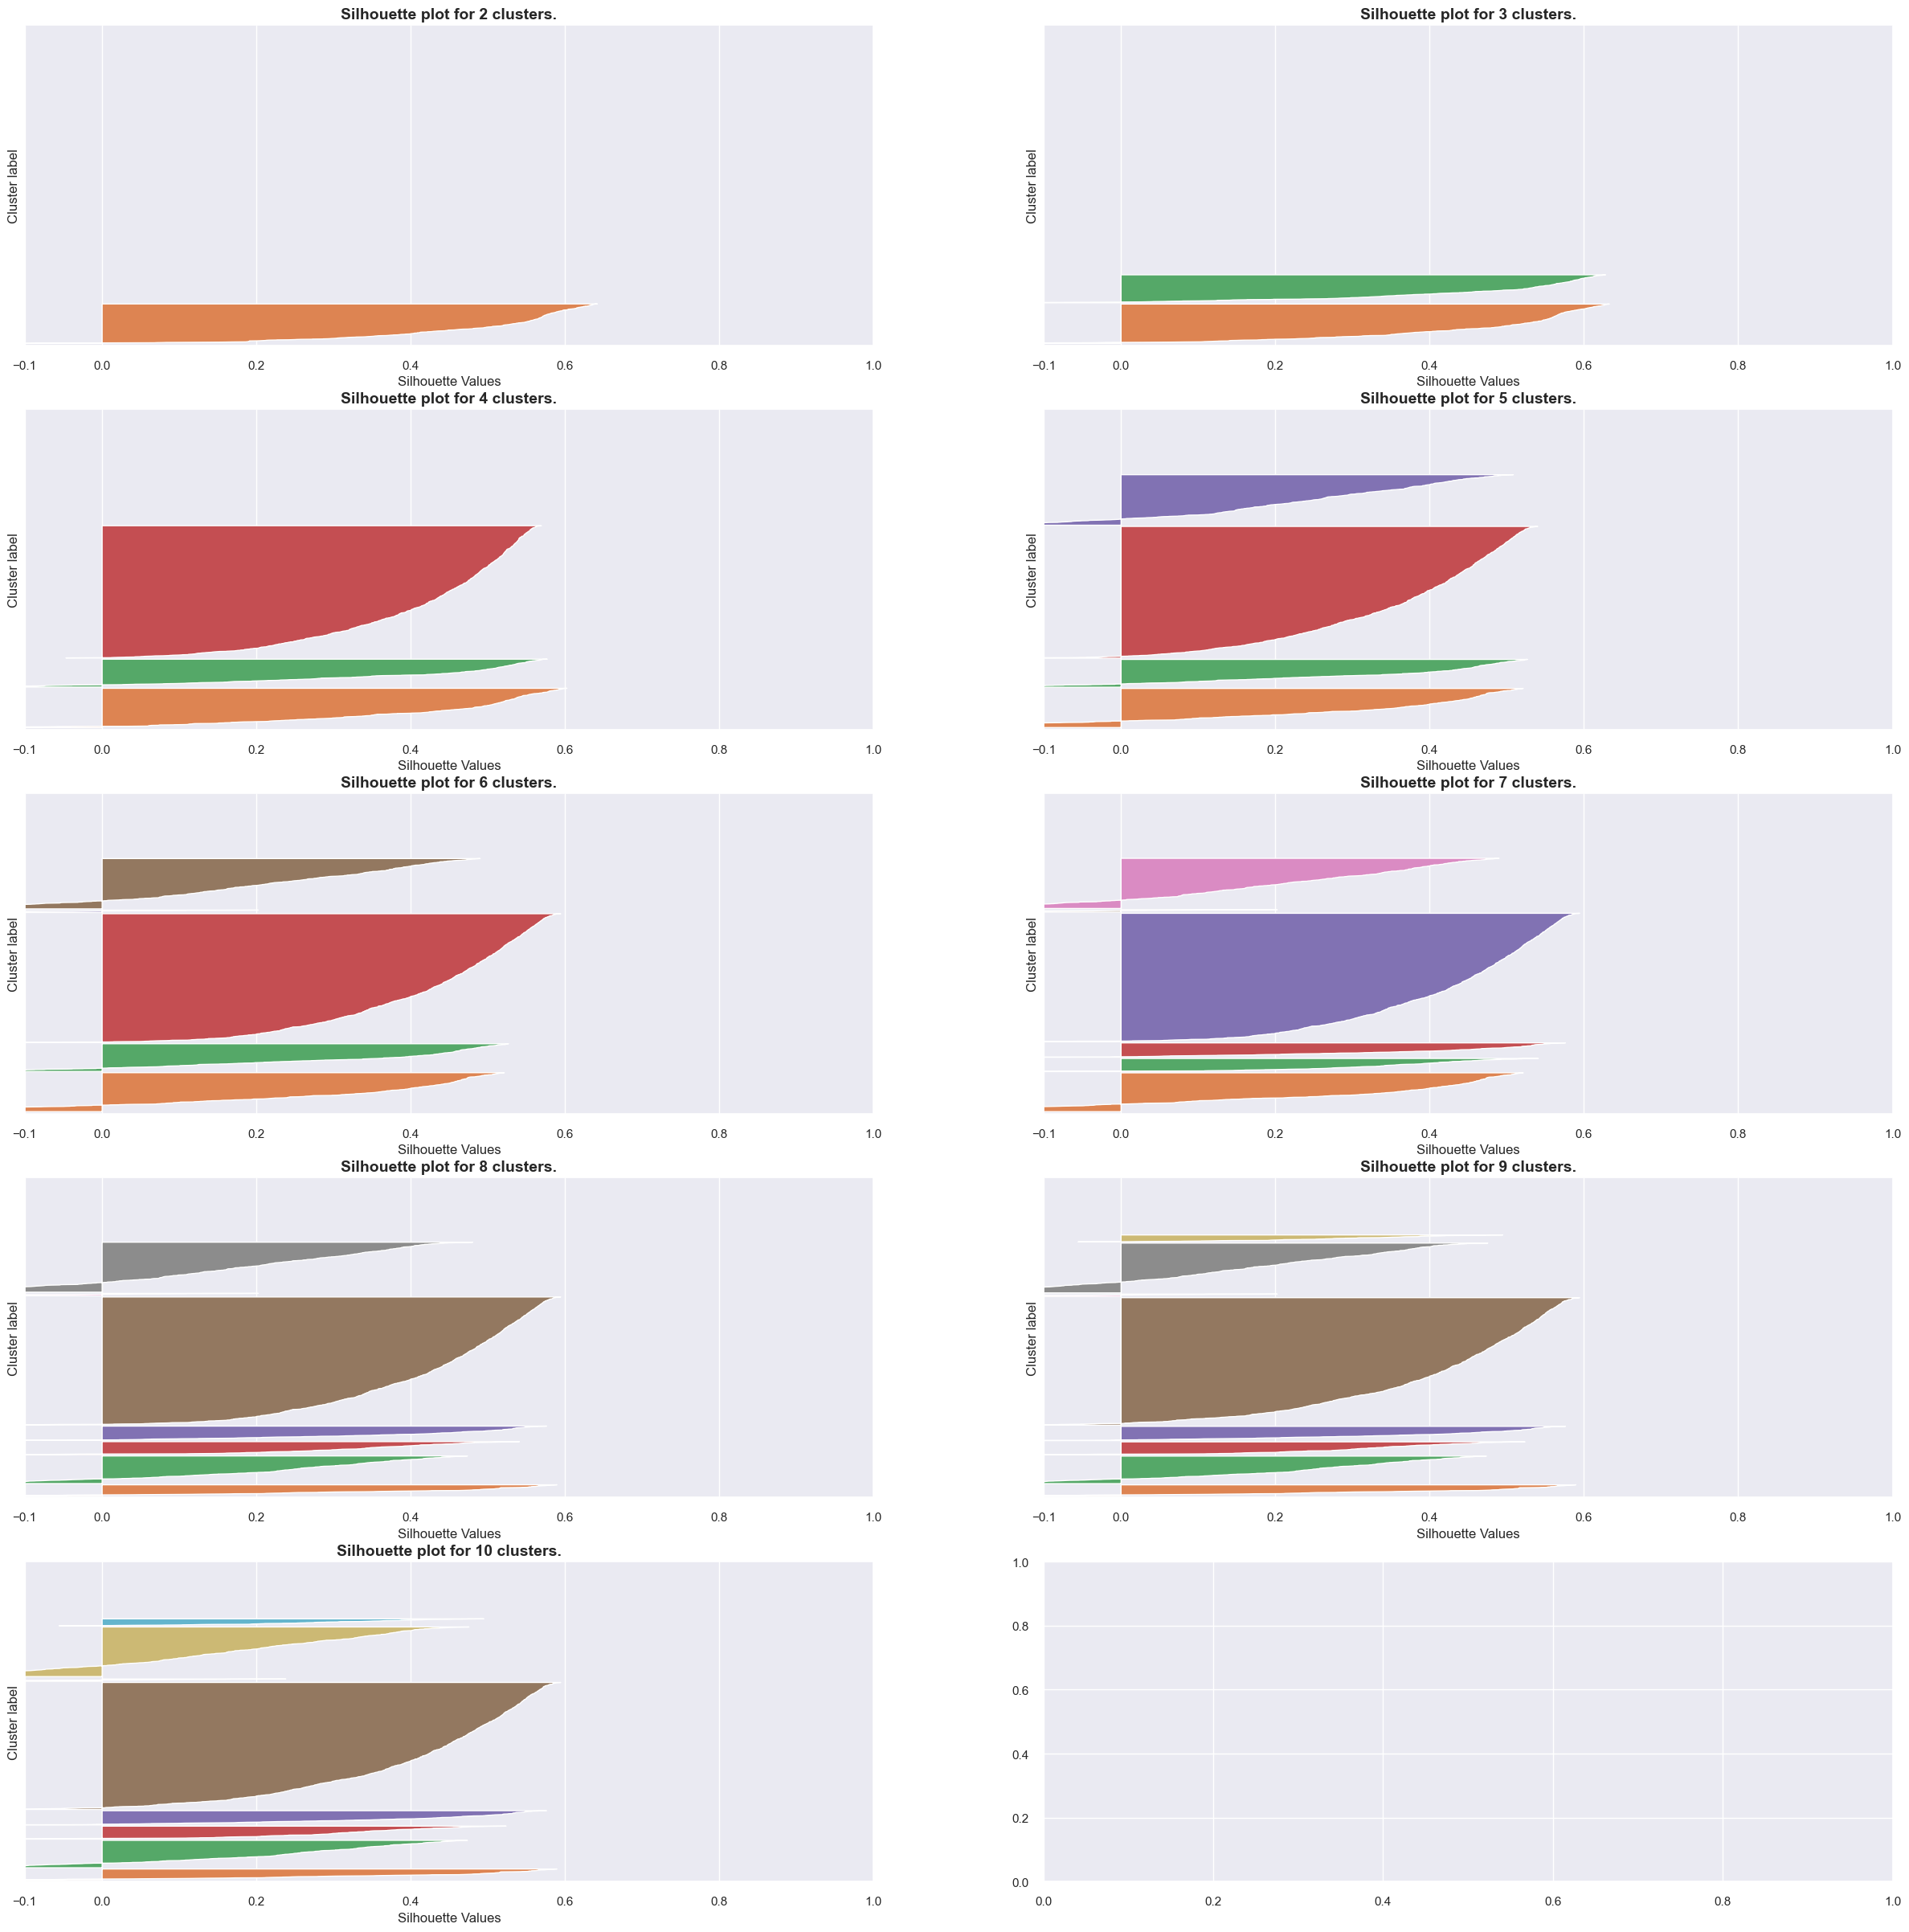

In [ ]:
plot_silhouette(X=X, clusters=clusters)

# 8.0 Machine Learning Modeling

## 8.1 Gaussian

In [115]:
# model definition
k=10
# Model definition
gmm_model = mx.GaussianMixture(n_components=k)
# Model training
gmm_model.fit(X)

# Model predict
labels = gmm_model.predict(X)


## 8.2 Cluster Validation

In [116]:
# WSS (Within_cluster sum of square)
#print(f'WSS Value: {kmeans.inertia_}')

# SS (Silhouette Score)
SS = m.silhouette_score(X, labels)
print(f'SS Value: {SS}')

SS Value: 0.5457984805107117


## 8.6 Compare Model's Performance

### 8.6.2 Real Performance - Cross Validation

# 9.0 Cluster Analysis

In [117]:
df9 = X.copy()
df9['cluster'] = labels
df9.head()

,embedding_x,embedding_y,cluster
0,-1.837,0.561,9
1,-5.014,-5.743,2
2,-6.398,10.351,3
3,20.119,2.443,4
4,9.679,11.520,1


## 9.1 Visualization Inspection

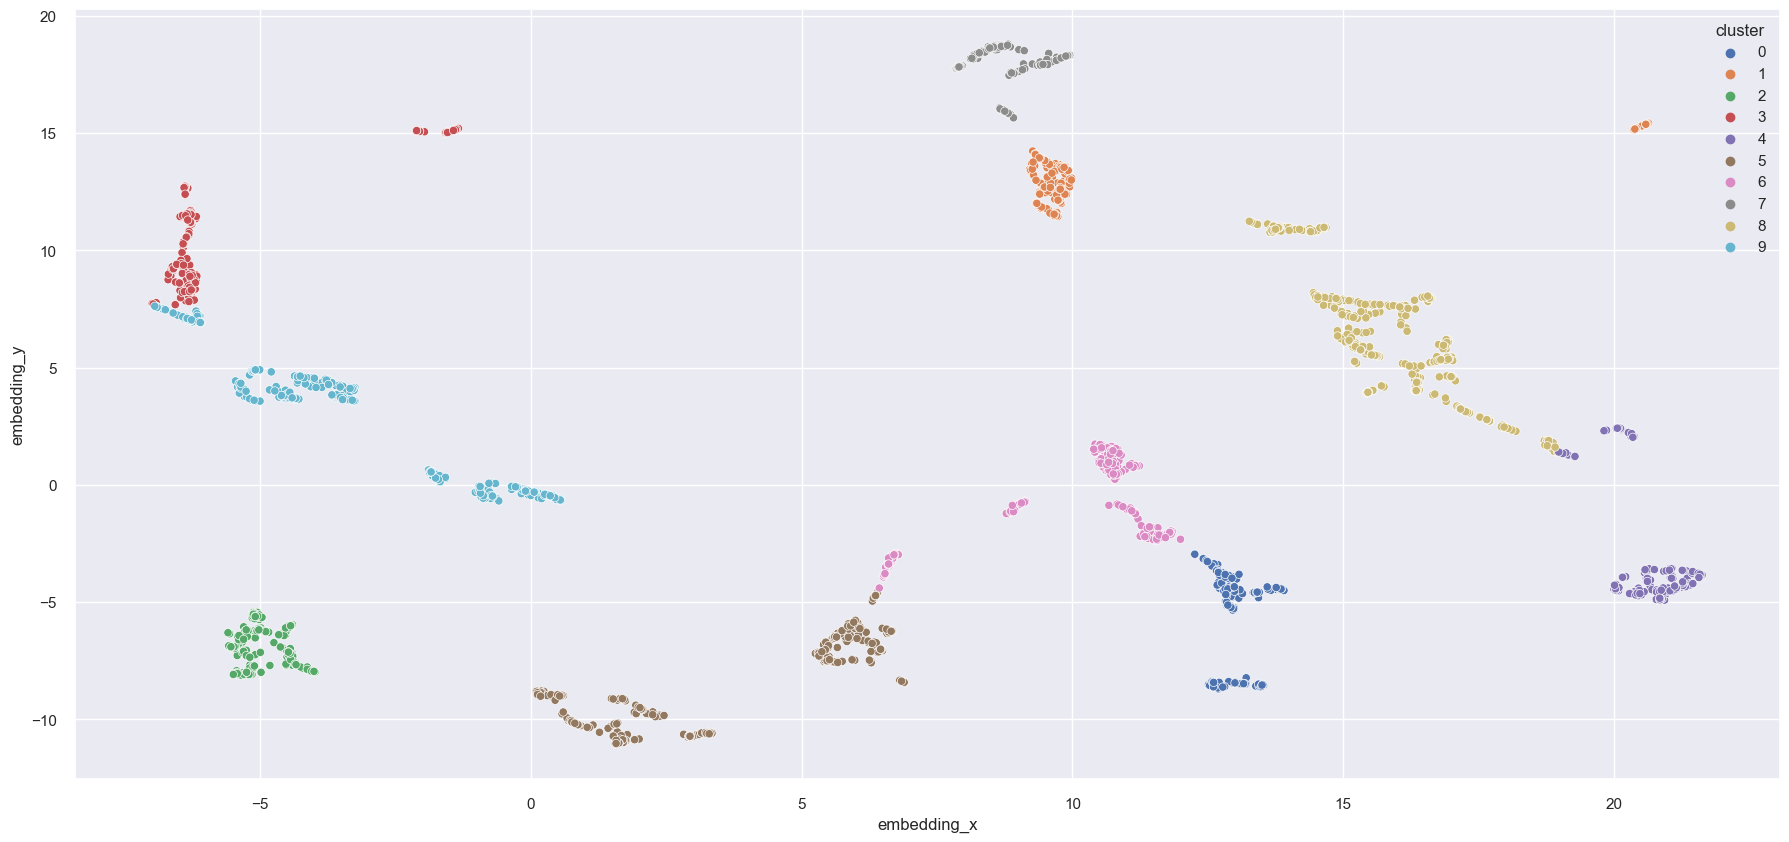

In [118]:
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep');

## 9.2 2D Plot

In [121]:
df_vis = df9.copy()
#sns.pairplot(df_vis, hue='cluster');

## 9.3 UMAP

In [123]:
#reducer = umap.UMAP(n_neighbors=80, random_state=42)
#embedding = reducer.fit_transform(X)

# Embedding
#df_vis['embedding_x'] = embedding[:,0]
#df_vis['embedding_y'] = embedding[:,1]

# Plot UMAP
#sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette=sns.color_palette('hls', n_colors=len(df_vis['cluster'].unique())), data=df_vis);

## 9.4 Cluster Profile

In [135]:
df9 = df4.reset_index( drop=True).copy()
df9['cluster'] = labels

# Number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Frequency
df_invoice_no = df9[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_invoice_no, how='inner', on='cluster')

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,frequency,avg_ticket
0,0,205,7.393,1264.481,60.873,0.036,27.649
1,1,190,6.852,464.306,92.647,0.039,37.604
2,2,205,7.393,2355.443,42.971,0.031,28.079
3,3,233,8.402,17648.090,19.459,0.082,94.790
4,4,211,7.609,859.527,68.166,0.039,22.183
5,5,379,13.668,1826.730,35.799,0.033,27.832
6,6,296,10.674,1044.745,62.348,0.041,23.296
7,7,169,6.094,236.305,100.657,0.071,19.317
8,8,496,17.887,616.153,77.871,0.044,20.631
9,9,389,14.028,3646.576,29.864,0.079,32.771


**Cluster 0:**

- Número de customer: 4.309 (99,51% dos customers)
- Recência em média: 92 dias
- Compras em média: 4 compras
- Receita em média: € 1.573,12
- Ticket médio: € 30,06

**Cluster 1:**

- Número de customer: 2 (0,04% dos customers)
- Recência em média: 162 dias
- Compras em média: 1 compras
- Receita em média: € 122.828,05
- Ticket médio: € 66.670,55

**Cluster 2: (Candidato a Insider)**

- Número de customer: 14 (0,32% dos customers)
- Recência em média: 7 dias
- Compras em média: 63 compras
- Receita em média: € 117.518,25
- Ticket médio: € 263,02

**Cluster 3:**

- Número de customer: 5 (0,11% dos customers)
- Recência em média: 181 dias
- Compras em média: 2 compras
- Receita em média: € 18.922,14
- Ticket médio: € 5.583,77

# 10.0 Deploy model to production